## Maske Oluşturma

In [15]:
import os
import numpy as np
from PIL import Image

def convert_red_overlays_to_masks(base_path, data_type):
    """
    OVERLAY klasöründeki kırmızı renkli lezyonları içeren PNG'leri okur,
    bunları hassas bir şekilde siyah-beyaz maskelere dönüştürür ve 'MASKS'
    klasörüne kaydeder.
    """
    overlay_folder = os.path.join(base_path, data_type, 'OVERLAY')
    mask_folder = os.path.join(base_path, data_type, 'MASKS')

    if not os.path.exists(mask_folder):
        os.makedirs(mask_folder)
        print(f"'{mask_folder}' klasörü oluşturuldu.")

    if not os.path.exists(overlay_folder):
        print(f"HATA: '{overlay_folder}' klasörü bulunamadı.")
        return
        
    overlay_files = [f for f in os.listdir(overlay_folder) if f.endswith('.png')]
    if not overlay_files:
        print(f"'{overlay_folder}' içinde işlenecek .png dosyası bulunamadı.")
        return

    print(f"'{overlay_folder}' klasöründeki {len(overlay_files)} kırmızı overlay dosyası işleniyor...")

    for filename in overlay_files:
        overlay_path = os.path.join(overlay_folder, filename)
        
        try:
            # Overlay PNG'sini aç ve 'RGB' formatına çevir (Alfa kanalını atıyoruz)
            overlay_img = Image.open(overlay_path).convert('RGB')
            
            # Görüntüyü NumPy dizisine çevir
            data = np.array(overlay_img)
            
            # Renk kanallarını ayır
            R = data[:, :, 0]
            G = data[:, :, 1]
            B = data[:, :, 2]
            
            # --- YENİ VE DOĞRU MANTIK ---
            # Bir pikselin lezyon olması için:
            # 1. Kırmızı kanalı belirli bir eşikten (gürültüyü önlemek için) yüksek olmalı.
            # 2. Kırmızı kanalı, hem yeşil hem de mavi kanaldan daha baskın olmalı.
            red_threshold = 50
            is_lesion = (R > red_threshold) & (R > G) & (R > B)
            
            # Boş (siyah) bir maske oluştur
            mask = np.zeros((data.shape[0], data.shape[1]), dtype=np.uint8)
            
            # Sadece lezyon olarak tespit edilen pikselleri beyaza (255) boya
            mask[is_lesion] = 255
            
            # NumPy dizisini tekrar PIL Görüntüsüne çevir
            mask_image = Image.fromarray(mask)
            
            # Yeni maske dosyasını MASKS klasörüne kaydet
            output_path = os.path.join(mask_folder, filename)
            mask_image.save(output_path)

        except Exception as e:
            print(f"HATA: '{filename}' işlenirken bir sorun oluştu: {e}")
            
    print(f"\nİşlem tamamlandı. Hassas maskeler '{mask_folder}' klasörüne kaydedildi.")

# --- KODU ÇALIŞTIRMA ---
ANA_VERI_YOLU = "Brain_Stroke_CT_Dataset" 

print("--- Bleeding için Kırmızı Lezyon Maskeleri oluşturuluyor ---")
convert_red_overlays_to_masks(ANA_VERI_YOLU, 'Bleeding')

print("\n--- Ischemia için Kırmızı Lezyon Maskeleri oluşturuluyor ---")
convert_red_overlays_to_masks(ANA_VERI_YOLU, 'Ischemia')

--- Bleeding için Kırmızı Lezyon Maskeleri oluşturuluyor ---
'Brain_Stroke_CT_Dataset\Bleeding\OVERLAY' klasöründeki 1093 kırmızı overlay dosyası işleniyor...

İşlem tamamlandı. Hassas maskeler 'Brain_Stroke_CT_Dataset\Bleeding\MASKS' klasörüne kaydedildi.

--- Ischemia için Kırmızı Lezyon Maskeleri oluşturuluyor ---
'Brain_Stroke_CT_Dataset\Ischemia\OVERLAY' klasöründeki 1130 kırmızı overlay dosyası işleniyor...

İşlem tamamlandı. Hassas maskeler 'Brain_Stroke_CT_Dataset\Ischemia\MASKS' klasörüne kaydedildi.


In [17]:
import os
import numpy as np
from PIL import Image

def overwrite_masks_with_color(base_path, data_type):
    """
    MASKS klasöründeki siyah-beyaz .png maskelerini okur.
    'Bleeding' için yeşile, 'Ischemia' için maviye boyar ve
    sonuçları doğrudan orijinal dosyaların üzerine kaydeder.
    """
    # Kaynak ve hedef klasör aynı: MASKS klasörü
    mask_folder = os.path.join(base_path, data_type, 'MASKS')

    if not os.path.exists(mask_folder):
        print(f"HATA: Klasör '{mask_folder}' bulunamadı.")
        return
        
    mask_files = [f for f in os.listdir(mask_folder) if f.endswith('.png')]
    if not mask_files:
        print(f"'{mask_folder}' içinde işlenecek .png dosyası bulunamadı.")
        return

    # Veri tipine göre kullanılacak rengi belirle
    target_color_name = ""
    target_color_rgb = (0, 0, 0) 

    if data_type == 'Bleeding':
        target_color_name = "yeşil"
        target_color_rgb = (0, 255, 0) # Saf Yeşil
    elif data_type == 'Ischemia':
        target_color_name = "mavi"
        target_color_rgb = (0, 0, 255) # Saf Mavi
    else:
        return

    print(f"'{mask_folder}' klasöründeki {len(mask_files)} maske {target_color_name} renge dönüştürülüp üzerlerine yazılacak...")

    for filename in mask_files:
        # Okunacak ve üzerine yazılacak dosyanın yolu
        mask_path = os.path.join(mask_folder, filename)
        
        try:
            # Siyah-beyaz maskeyi aç
            bw_mask_img = Image.open(mask_path).convert('L')
            bw_mask_array = np.array(bw_mask_img)
            
            # 3 kanallı (RGB), tamamen siyah yeni bir görüntü için array oluştur
            color_mask_array = np.zeros((bw_mask_array.shape[0], bw_mask_array.shape[1], 3), dtype=np.uint8)
            
            # Orijinal maskede beyaz olan piksellerin konumlarını bul
            white_pixels = bw_mask_array > 0
            
            # Renkli maskede bu konumlara hedef rengi ata
            color_mask_array[white_pixels] = target_color_rgb
            
            # Array'i tekrar görsele çevir
            color_mask_image = Image.fromarray(color_mask_array)
            
            # Yeni renkli maskeyi ORİJİNAL DOSYANIN ÜZERİNE kaydet
            color_mask_image.save(mask_path)

        except Exception as e:
            print(f"HATA: '{filename}' işlenirken bir sorun oluştu: {e}")
            
    print(f"\nİşlem tamamlandı. '{mask_folder}' klasöründeki maskeler renklendirildi.")

# --- KODU ÇALIŞTIRMA ---
ANA_VERI_YOLU = "Brain_Stroke_CT_Dataset" 

print("--- Bleeding maskeleri yeşile boyanıyor (üzerine yazma) ---")
overwrite_masks_with_color(ANA_VERI_YOLU, 'Bleeding')

print("\n--- Ischemia maskeleri maviye boyanıyor (üzerine yazma) ---")
overwrite_masks_with_color(ANA_VERI_YOLU, 'Ischemia')

--- Bleeding maskeleri yeşile boyanıyor (üzerine yazma) ---
'Brain_Stroke_CT_Dataset\Bleeding\MASKS' klasöründeki 1093 maske yeşil renge dönüştürülüp üzerlerine yazılacak...

İşlem tamamlandı. 'Brain_Stroke_CT_Dataset\Bleeding\MASKS' klasöründeki maskeler renklendirildi.

--- Ischemia maskeleri maviye boyanıyor (üzerine yazma) ---
'Brain_Stroke_CT_Dataset\Ischemia\MASKS' klasöründeki 1130 maske mavi renge dönüştürülüp üzerlerine yazılacak...

İşlem tamamlandı. 'Brain_Stroke_CT_Dataset\Ischemia\MASKS' klasöründeki maskeler renklendirildi.


## Segmentation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import warnings
import glob
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.5.1
CUDA Available: True
CUDA Device: NVIDIA GeForce RTX 2070
Using device: cuda


In [2]:
DATA_DIR = r"C:\Users\omer_\Documents\GitHub\ytustats\standard_u-net\Brain_Stroke_CT_Dataset"

# Bleeding ve Ischemia için görüntü ve maske yollarını toplayalım
image_files = []
mask_files = []

# Sadece lezyon içeren sınıfları alıyoruz (Normal sınıfını segmentasyonda kullanmıyoruz)
LESION_CLASSES = ["Bleeding", "Ischemia"]

print("Segmentasyon için görüntü ve maskeler eşleştiriliyor...")
for class_name in LESION_CLASSES:
    image_dir = os.path.join(DATA_DIR, class_name, 'PNG')      # Orijinal PNG'lerin yolu
    mask_dir = os.path.join(DATA_DIR, class_name, 'MASKS')     # Renklendirdiğimiz maskelerin yolu
    
    if not os.path.isdir(image_dir):
        print(f"UYARI: Görüntü klasörü bulunamadı: {image_dir}")
        continue
    if not os.path.isdir(mask_dir):
        print(f"UYARI: Maske klasörü bulunamadı: {mask_dir}")
        continue
        
    # Her bir görüntü dosyası için maske karşılığını bul
    for image_name in os.listdir(image_dir):
        if image_name.endswith('.png'):
            image_path = os.path.join(image_dir, image_name)
            mask_path = os.path.join(mask_dir, image_name)
            
            # Eğer görüntünün bir maske karşılığı varsa listeye ekle
            if os.path.exists(mask_path):
                image_files.append(image_path)
                mask_files.append(mask_path)

print(f"Toplam {len(image_files)} adet eşleşmiş görüntü ve maske bulundu.")

# Veriyi Eğitim (%80) ve Doğrulama (%20) olarak ayıralım
# Test setini daha sonra ayırabiliriz veya doğrulama setini kullanabiliriz.
X_train, X_val, y_train, y_val = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=42
)

print(f"\nVeri seti ayrıldı:")
print(f"Eğitim seti boyutu: {len(X_train)}")
print(f"Doğrulama seti boyutu: {len(X_val)}")

Segmentasyon için görüntü ve maskeler eşleştiriliyor...
Toplam 2223 adet eşleşmiş görüntü ve maske bulundu.

Veri seti ayrıldı:
Eğitim seti boyutu: 1778
Doğrulama seti boyutu: 445


In [3]:
# Bu hücreyi notebook'una ekle

IMAGE_SIZE = 256 # Modelimize girecek görüntülerin boyutu

# Eğitim seti için daha zengin bir artırma paketi
train_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=15, p=0.7),
    A.RandomBrightnessContrast(p=0.5),
    A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03), # <-- YENİ EKLENTİ
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
])

# Doğrulama seti için sadece yeniden boyutlandırma ve standartlaştırma
val_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
])

In [4]:
class StrokeDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Görüntü ve maske yollarını al
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        # Görüntüyü ve renkli maskeyi oku
        # cv2 BGR formatında okur, RGB'ye çeviriyoruz
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        colored_mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2RGB)

        # Renkli maskeyi (Yeşil, Mavi) sınıf indekslerine (1, 2) dönüştür
        # Arka plan: 0, Bleeding (Yeşil): 1, Ischemia (Mavi): 2
        mask = np.zeros((colored_mask.shape[0], colored_mask.shape[1]), dtype=np.int64)
        mask[np.all(colored_mask == [0, 255, 0], axis=-1)] = 1 # Yeşil pikselleri 1 yap
        mask[np.all(colored_mask == [0, 0, 255], axis=-1)] = 2 # Mavi pikselleri 2 yap

        # Eğer augmentasyon tanımlıysa uygula
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        
        return image, mask

# Dataset nesnelerini oluşturalım
train_dataset = StrokeDataset(X_train, y_train, transform=train_transform)
val_dataset = StrokeDataset(X_val, y_val, transform=val_transform)

BATCH_SIZE = 8

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=0,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, 
    num_workers=0,
)

print(f"DataLoader'lar `num_workers=0` ile yeniden yapılandırıldı.")
print(f"Eğitim için {len(train_loader)} batch, Doğrulama için {len(val_loader)} batch oluşturuldu.")

DataLoader'lar `num_workers=0` ile yeniden yapılandırıldı.
Eğitim için 223 batch, Doğrulama için 56 batch oluşturuldu.


In [5]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss, FocalLoss

# --- MODELİ OLUŞTURMA ---
ENCODER = 'resnet50' 
ENCODER_WEIGHTS = 'imagenet'
NUM_CLASSES = 3 

model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    in_channels=3,
    classes=NUM_CLASSES,
).to(device)

# --- KAYIP FONKSİYONU VE OPTIMIZER ---

# 1. loss_fn: Bu, en iyi sonucumuzu veren kombine kayıp fonksiyonu. AYNI KALIYOR.
dice_loss = DiceLoss(mode='multiclass', from_logits=True)
focal_loss = FocalLoss(mode='multiclass', gamma=2.0)
loss_fn = lambda pred, target: 0.5 * dice_loss(pred, target) + 0.5 * focal_loss(pred, target)

# 2. learning rate: Optimizer içindeki bu değer de en iyi sonucumuzu veren değer. AYNI KALIYOR.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) 
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

print(f"Model: {ENCODER} tabanlı U-Net")
print("Kayıp Fonksiyonu: Kombine (0.5 * DiceLoss + 0.5 * FocalLoss)")
print(f"Model, eğitim için '{device}' üzerinde hazır.")

Model: resnet50 tabanlı U-Net
Kayıp Fonksiyonu: Kombine (0.5 * DiceLoss + 0.5 * FocalLoss)
Model, eğitim için 'cuda' üzerinde hazır.


In [6]:
def train_fn(loader, model, optimizer, loss_fn, device):
    """Bir epoch'luk eğitim döngüsünü çalıştırır ve loss, dice, iou döndürür."""
    model.train()
    loop = tqdm(loader, desc="Eğitim")
    total_loss, total_tp, total_fp, total_fn = 0.0, 0, 0, 0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=device, dtype=torch.float32)
        targets = targets.to(device=device, dtype=torch.long)
        
        predictions = model(data)
        loss = loss_fn(predictions, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        preds_mask = torch.argmax(predictions, dim=1)
        y_lesion = (targets > 0)
        preds_lesion = (preds_mask > 0)
        total_tp += (y_lesion & preds_lesion).sum().item()
        total_fp += (~y_lesion & preds_lesion).sum().item()
        total_fn += (y_lesion & ~preds_lesion).sum().item()

    avg_loss = total_loss / len(loader)
    avg_dice = (2. * total_tp) / (2 * total_tp + total_fp + total_fn + 1e-8)
    avg_iou = total_tp / (total_tp + total_fp + total_fn + 1e-8)
    
    return avg_loss, avg_dice, avg_iou

def evaluate_epoch(loader, model, loss_fn, device):
    """Bir epoch sonunda tüm metrikleri (loss, dice, iou, sens, spec, acc) hesaplar."""
    model.eval()
    total_loss, total_tp, total_tn, total_fp, total_fn = 0, 0, 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device, dtype=torch.float32), y.to(device, dtype=torch.long)
            preds = model(x)
            total_loss += loss_fn(preds, y).item()
            preds_mask = torch.argmax(preds, dim=1)
            y_lesion, preds_lesion = (y > 0), (preds_mask > 0)
            y_bg, preds_bg = (y == 0), (preds_mask == 0)
            total_tp += (y_lesion & preds_lesion).sum().item()
            total_tn += (y_bg & preds_bg).sum().item()
            total_fp += (~y_lesion & preds_lesion).sum().item()
            total_fn += (y_lesion & ~preds_lesion).sum().item()
    metrics = {
        "loss": total_loss / len(loader),
        "dice": (2. * total_tp) / (2 * total_tp + total_fp + total_fn + 1e-8),
        "iou": total_tp / (total_tp + total_fp + total_fn + 1e-8),
        "sensitivity": total_tp / (total_tp + total_fn + 1e-8),
        "specificity": total_tn / (total_tn + total_fp + 1e-8),
        "accuracy": (total_tp + total_tn) / (total_tp + total_tn + total_fp + total_fn + 1e-8)
    }
    return metrics

def plot_training_history(history):
    """Tüm metrikleri içeren 6'lı bir grafik paneli çizer."""
    metrics_to_plot_val = ['val_dice', 'val_iou', 'val_sensitivity', 'val_specificity', 'val_accuracy']
    metrics_to_plot_train = ['train_dice', 'train_iou']
    metric_names_turkish = ['Dice Skoru', 'IoU Skoru', 'Hassasiyet (Recall)', 'Özgüllük (Specificity)', 'Doğruluk (Accuracy)']
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Epoch Bazında Model Performans Metrikleri', fontsize=20)
    axes = axes.flatten()
    epochs_range = range(1, len(history['train_loss']) + 1)

    # 1. Kayıp Grafiği
    axes[0].plot(epochs_range, history['train_loss'], 'o-', label='Eğitim Kaybı')
    axes[0].plot(epochs_range, history['val_loss'], 'o-', label='Doğrulama Kaybı')
    axes[0].set_title('Model Kaybı'); axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Kayıp'); axes[0].legend(); axes[0].grid(True)

    # 2. Dice ve IoU Grafikleri (Eğitim & Doğrulama)
    axes[1].plot(epochs_range, history['train_dice'], 'o-', label='Eğitim Dice')
    axes[1].plot(epochs_range, history['val_dice'], 'o-', label='Doğrulama Dice')
    axes[1].set_title('Dice Skoru'); axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Dice'); axes[1].legend(); axes[1].grid(True); axes[1].set_ylim(0,1)

    axes[2].plot(epochs_range, history['train_iou'], 'o-', label='Eğitim IoU')
    axes[2].plot(epochs_range, history['val_iou'], 'o-', label='Doğrulama IoU')
    axes[2].set_title('IoU Skoru'); axes[2].set_xlabel('Epoch'); axes[2].set_ylabel('IoU'); axes[2].legend(); axes[2].grid(True); axes[2].set_ylim(0,1)

    # 3. Kalan Doğrulama Metrikleri
    axes[3].plot(epochs_range, history['val_sensitivity'], 'o-', color='green', label='Doğrulama Hassasiyet')
    axes[3].set_title('Hassasiyet (Recall)'); axes[3].set_xlabel('Epoch'); axes[3].set_ylabel('Skor'); axes[3].legend(); axes[3].grid(True); axes[3].set_ylim(0,1)
    
    axes[4].plot(epochs_range, history['val_specificity'], 'o-', color='purple', label='Doğrulama Özgüllük')
    axes[4].set_title('Özgüllük (Specificity)'); axes[4].set_xlabel('Epoch'); axes[4].set_ylabel('Skor'); axes[4].legend(); axes[4].grid(True); # Y-limiti otomatik ayarla
    
    axes[5].plot(epochs_range, history['val_accuracy'], 'o-', color='brown', label='Doğrulama Doğruluk')
    axes[5].set_title('Doğruluk (Accuracy)'); axes[5].set_xlabel('Epoch'); axes[5].set_ylabel('Skor'); axes[5].legend(); axes[5].grid(True); # Y-limiti otomatik ayarla

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

--- Epoch 1/50 ---


Eğitim: 100%|██████████| 223/223 [00:58<00:00,  3.81it/s]


Train -> Loss: 0.4516, Dice: 0.0499
Val   -> Loss: 0.3628, Dice: 0.1209, Sens: 0.0650
==> Yeni en iyi model kaydedildi (Dice Skoru: 0.1209)
--- Epoch 2/50 ---


Eğitim: 100%|██████████| 223/223 [00:59<00:00,  3.77it/s]


Train -> Loss: 0.3185, Dice: 0.4792
Val   -> Loss: 0.2914, Dice: 0.4676, Sens: 0.7180
==> Yeni en iyi model kaydedildi (Dice Skoru: 0.4676)
--- Epoch 3/50 ---


Eğitim: 100%|██████████| 223/223 [00:59<00:00,  3.74it/s]


Train -> Loss: 0.2375, Dice: 0.5654
Val   -> Loss: 0.1983, Dice: 0.6448, Sens: 0.6530
==> Yeni en iyi model kaydedildi (Dice Skoru: 0.6448)
--- Epoch 4/50 ---


Eğitim: 100%|██████████| 223/223 [00:59<00:00,  3.73it/s]


Train -> Loss: 0.1763, Dice: 0.6244
Val   -> Loss: 0.1556, Dice: 0.6928, Sens: 0.6534
==> Yeni en iyi model kaydedildi (Dice Skoru: 0.6928)
--- Epoch 5/50 ---


Eğitim: 100%|██████████| 223/223 [00:59<00:00,  3.73it/s]


Train -> Loss: 0.1513, Dice: 0.6525
Val   -> Loss: 0.1332, Dice: 0.7192, Sens: 0.6671
==> Yeni en iyi model kaydedildi (Dice Skoru: 0.7192)
--- Epoch 6/50 ---


Eğitim: 100%|██████████| 223/223 [01:01<00:00,  3.65it/s]


Train -> Loss: 0.1381, Dice: 0.6775
Val   -> Loss: 0.1280, Dice: 0.7259, Sens: 0.6522
==> Yeni en iyi model kaydedildi (Dice Skoru: 0.7259)
--- Epoch 7/50 ---


Eğitim: 100%|██████████| 223/223 [01:00<00:00,  3.70it/s]


Train -> Loss: 0.1293, Dice: 0.6904
Val   -> Loss: 0.1209, Dice: 0.7168, Sens: 0.7563
--- Epoch 8/50 ---


Eğitim: 100%|██████████| 223/223 [01:00<00:00,  3.70it/s]


Train -> Loss: 0.1241, Dice: 0.7060
Val   -> Loss: 0.1164, Dice: 0.7350, Sens: 0.7122
==> Yeni en iyi model kaydedildi (Dice Skoru: 0.7350)
--- Epoch 9/50 ---


Eğitim: 100%|██████████| 223/223 [00:59<00:00,  3.73it/s]


Train -> Loss: 0.1202, Dice: 0.7140
Val   -> Loss: 0.1174, Dice: 0.7313, Sens: 0.6934
--- Epoch 10/50 ---


Eğitim: 100%|██████████| 223/223 [01:00<00:00,  3.69it/s]


Train -> Loss: 0.1168, Dice: 0.7190
Val   -> Loss: 0.1099, Dice: 0.7507, Sens: 0.7099
==> Yeni en iyi model kaydedildi (Dice Skoru: 0.7507)
--- Epoch 11/50 ---


Eğitim: 100%|██████████| 223/223 [01:00<00:00,  3.68it/s]


Train -> Loss: 0.1167, Dice: 0.7256
Val   -> Loss: 0.1223, Dice: 0.7279, Sens: 0.6318
--- Epoch 12/50 ---


Eğitim: 100%|██████████| 223/223 [01:00<00:00,  3.68it/s]


Train -> Loss: 0.1082, Dice: 0.7418
Val   -> Loss: 0.1063, Dice: 0.7556, Sens: 0.7261
==> Yeni en iyi model kaydedildi (Dice Skoru: 0.7556)
--- Epoch 13/50 ---


Eğitim: 100%|██████████| 223/223 [00:58<00:00,  3.82it/s]


Train -> Loss: 0.1063, Dice: 0.7474
Val   -> Loss: 0.1493, Dice: 0.6553, Sens: 0.6538
--- Epoch 14/50 ---


Eğitim: 100%|██████████| 223/223 [00:57<00:00,  3.85it/s]


Train -> Loss: 0.1085, Dice: 0.7364
Val   -> Loss: 0.1080, Dice: 0.7523, Sens: 0.6826
--- Epoch 15/50 ---


Eğitim: 100%|██████████| 223/223 [00:57<00:00,  3.88it/s]


Train -> Loss: 0.1040, Dice: 0.7543
Val   -> Loss: 0.1081, Dice: 0.7474, Sens: 0.7023
--- Epoch 16/50 ---


Eğitim: 100%|██████████| 223/223 [00:57<00:00,  3.87it/s]


Train -> Loss: 0.1028, Dice: 0.7570
Val   -> Loss: 0.1015, Dice: 0.7640, Sens: 0.7220
==> Yeni en iyi model kaydedildi (Dice Skoru: 0.7640)
--- Epoch 17/50 ---


Eğitim: 100%|██████████| 223/223 [01:00<00:00,  3.70it/s]


Train -> Loss: 0.0972, Dice: 0.7667
Val   -> Loss: 0.1074, Dice: 0.7473, Sens: 0.6863
--- Epoch 18/50 ---


Eğitim: 100%|██████████| 223/223 [01:00<00:00,  3.70it/s]


Train -> Loss: 0.0947, Dice: 0.7756
Val   -> Loss: 0.0997, Dice: 0.7707, Sens: 0.7415
==> Yeni en iyi model kaydedildi (Dice Skoru: 0.7707)
--- Epoch 19/50 ---


Eğitim: 100%|██████████| 223/223 [01:01<00:00,  3.66it/s]


Train -> Loss: 0.0974, Dice: 0.7608
Val   -> Loss: 0.1074, Dice: 0.7553, Sens: 0.6949
--- Epoch 20/50 ---


Eğitim: 100%|██████████| 223/223 [01:00<00:00,  3.71it/s]


Train -> Loss: 0.1011, Dice: 0.7637
Val   -> Loss: 0.1024, Dice: 0.7661, Sens: 0.7136
--- Epoch 21/50 ---


Eğitim: 100%|██████████| 223/223 [01:00<00:00,  3.70it/s]


Train -> Loss: 0.0930, Dice: 0.7737
Val   -> Loss: 0.0995, Dice: 0.7627, Sens: 0.7462
--- Epoch 22/50 ---


Eğitim: 100%|██████████| 223/223 [01:00<00:00,  3.70it/s]


Train -> Loss: 0.0958, Dice: 0.7702
Val   -> Loss: 0.0939, Dice: 0.7749, Sens: 0.7789
==> Yeni en iyi model kaydedildi (Dice Skoru: 0.7749)
--- Epoch 23/50 ---


Eğitim: 100%|██████████| 223/223 [01:01<00:00,  3.64it/s]


Train -> Loss: 0.0925, Dice: 0.7836
Val   -> Loss: 0.0971, Dice: 0.7745, Sens: 0.7416
--- Epoch 24/50 ---


Eğitim: 100%|██████████| 223/223 [01:00<00:00,  3.70it/s]


Train -> Loss: 0.0961, Dice: 0.7706
Val   -> Loss: 0.0995, Dice: 0.7732, Sens: 0.7015
--- Epoch 25/50 ---


Eğitim: 100%|██████████| 223/223 [01:01<00:00,  3.64it/s]


Train -> Loss: 0.0943, Dice: 0.7820
Val   -> Loss: 0.1020, Dice: 0.7637, Sens: 0.6965
--- Epoch 26/50 ---


Eğitim: 100%|██████████| 223/223 [01:00<00:00,  3.69it/s]


Train -> Loss: 0.0932, Dice: 0.7774
Val   -> Loss: 0.0967, Dice: 0.7629, Sens: 0.8005
--- Epoch 27/50 ---


Eğitim: 100%|██████████| 223/223 [01:00<00:00,  3.68it/s]


Train -> Loss: 0.0869, Dice: 0.7925
Val   -> Loss: 0.0992, Dice: 0.7579, Sens: 0.8074
--- Epoch 28/50 ---


Eğitim: 100%|██████████| 223/223 [01:00<00:00,  3.72it/s]


Train -> Loss: 0.0989, Dice: 0.7585
Val   -> Loss: 0.0943, Dice: 0.7731, Sens: 0.7762
--- Epoch 29/50 ---


Eğitim: 100%|██████████| 223/223 [01:00<00:00,  3.67it/s]


Train -> Loss: 0.0826, Dice: 0.8036
Val   -> Loss: 0.0904, Dice: 0.7841, Sens: 0.7716
==> Yeni en iyi model kaydedildi (Dice Skoru: 0.7841)
--- Epoch 30/50 ---


Eğitim: 100%|██████████| 223/223 [01:01<00:00,  3.62it/s]


Train -> Loss: 0.0773, Dice: 0.8118
Val   -> Loss: 0.0892, Dice: 0.7879, Sens: 0.7767
==> Yeni en iyi model kaydedildi (Dice Skoru: 0.7879)
--- Epoch 31/50 ---


Eğitim: 100%|██████████| 223/223 [00:59<00:00,  3.74it/s]


Train -> Loss: 0.0790, Dice: 0.8110
Val   -> Loss: 0.0899, Dice: 0.7887, Sens: 0.7535
==> Yeni en iyi model kaydedildi (Dice Skoru: 0.7887)
--- Epoch 32/50 ---


Eğitim: 100%|██████████| 223/223 [00:59<00:00,  3.73it/s]


Train -> Loss: 0.0798, Dice: 0.8151
Val   -> Loss: 0.0884, Dice: 0.7905, Sens: 0.7707
==> Yeni en iyi model kaydedildi (Dice Skoru: 0.7905)
--- Epoch 33/50 ---


Eğitim: 100%|██████████| 223/223 [01:01<00:00,  3.63it/s]


Train -> Loss: 0.0759, Dice: 0.8187
Val   -> Loss: 0.0891, Dice: 0.7914, Sens: 0.7530
==> Yeni en iyi model kaydedildi (Dice Skoru: 0.7914)
--- Epoch 34/50 ---


Eğitim: 100%|██████████| 223/223 [01:01<00:00,  3.65it/s]


Train -> Loss: 0.0765, Dice: 0.8193
Val   -> Loss: 0.0872, Dice: 0.7911, Sens: 0.7839
--- Epoch 35/50 ---


Eğitim: 100%|██████████| 223/223 [00:57<00:00,  3.85it/s]


Train -> Loss: 0.0746, Dice: 0.8243
Val   -> Loss: 0.0871, Dice: 0.7915, Sens: 0.7861
==> Yeni en iyi model kaydedildi (Dice Skoru: 0.7915)
--- Epoch 36/50 ---


Eğitim: 100%|██████████| 223/223 [00:58<00:00,  3.83it/s]


Train -> Loss: 0.0745, Dice: 0.8236
Val   -> Loss: 0.0870, Dice: 0.7945, Sens: 0.7736
==> Yeni en iyi model kaydedildi (Dice Skoru: 0.7945)
--- Epoch 37/50 ---


Eğitim: 100%|██████████| 223/223 [00:59<00:00,  3.73it/s]


Train -> Loss: 0.0732, Dice: 0.8272
Val   -> Loss: 0.0856, Dice: 0.7959, Sens: 0.7854
==> Yeni en iyi model kaydedildi (Dice Skoru: 0.7959)
--- Epoch 38/50 ---


Eğitim: 100%|██████████| 223/223 [01:00<00:00,  3.70it/s]


Train -> Loss: 0.0730, Dice: 0.8260
Val   -> Loss: 0.0858, Dice: 0.7976, Sens: 0.7816
==> Yeni en iyi model kaydedildi (Dice Skoru: 0.7976)
--- Epoch 39/50 ---


Eğitim: 100%|██████████| 223/223 [01:00<00:00,  3.71it/s]


Train -> Loss: 0.0721, Dice: 0.8281
Val   -> Loss: 0.0868, Dice: 0.7964, Sens: 0.7799
--- Epoch 40/50 ---


Eğitim: 100%|██████████| 223/223 [01:00<00:00,  3.70it/s]


Train -> Loss: 0.0720, Dice: 0.8286
Val   -> Loss: 0.0866, Dice: 0.7975, Sens: 0.7628
--- Epoch 41/50 ---


Eğitim: 100%|██████████| 223/223 [01:00<00:00,  3.67it/s]


Train -> Loss: 0.0700, Dice: 0.8321
Val   -> Loss: 0.0858, Dice: 0.7997, Sens: 0.7720
==> Yeni en iyi model kaydedildi (Dice Skoru: 0.7997)
--- Epoch 42/50 ---


Eğitim: 100%|██████████| 223/223 [01:00<00:00,  3.67it/s]


Train -> Loss: 0.0715, Dice: 0.8307
Val   -> Loss: 0.0859, Dice: 0.7968, Sens: 0.7864
--- Epoch 43/50 ---


Eğitim: 100%|██████████| 223/223 [01:04<00:00,  3.46it/s]


Train -> Loss: 0.0710, Dice: 0.8302
Val   -> Loss: 0.0863, Dice: 0.7951, Sens: 0.7835
--- Epoch 44/50 ---


Eğitim: 100%|██████████| 223/223 [01:04<00:00,  3.48it/s]


Train -> Loss: 0.0713, Dice: 0.8337
Val   -> Loss: 0.0861, Dice: 0.7984, Sens: 0.7725
--- Epoch 45/50 ---


Eğitim: 100%|██████████| 223/223 [01:10<00:00,  3.17it/s]


Train -> Loss: 0.0711, Dice: 0.8328
Val   -> Loss: 0.0860, Dice: 0.7952, Sens: 0.7865
--- Epoch 46/50 ---


Eğitim: 100%|██████████| 223/223 [01:14<00:00,  3.01it/s]


Train -> Loss: 0.0705, Dice: 0.8343
Val   -> Loss: 0.0857, Dice: 0.7973, Sens: 0.7821
--- Epoch 47/50 ---


Eğitim: 100%|██████████| 223/223 [01:08<00:00,  3.25it/s]


Train -> Loss: 0.0690, Dice: 0.8359
Val   -> Loss: 0.0853, Dice: 0.7984, Sens: 0.7843
--- Epoch 48/50 ---


Eğitim: 100%|██████████| 223/223 [01:03<00:00,  3.49it/s]


Train -> Loss: 0.0681, Dice: 0.8344
Val   -> Loss: 0.0853, Dice: 0.7986, Sens: 0.7820
--- Epoch 49/50 ---


Eğitim: 100%|██████████| 223/223 [01:14<00:00,  3.00it/s]


Train -> Loss: 0.0691, Dice: 0.8356
Val   -> Loss: 0.0850, Dice: 0.7992, Sens: 0.7822
--- Epoch 50/50 ---


Eğitim: 100%|██████████| 223/223 [01:12<00:00,  3.07it/s]


Train -> Loss: 0.0694, Dice: 0.8363
Val   -> Loss: 0.0850, Dice: 0.7995, Sens: 0.7858

Eğitim tamamlandı!
En iyi doğrulama Dice Skoru: 0.7997

Eğitim geçmişi grafikleri oluşturuluyor...


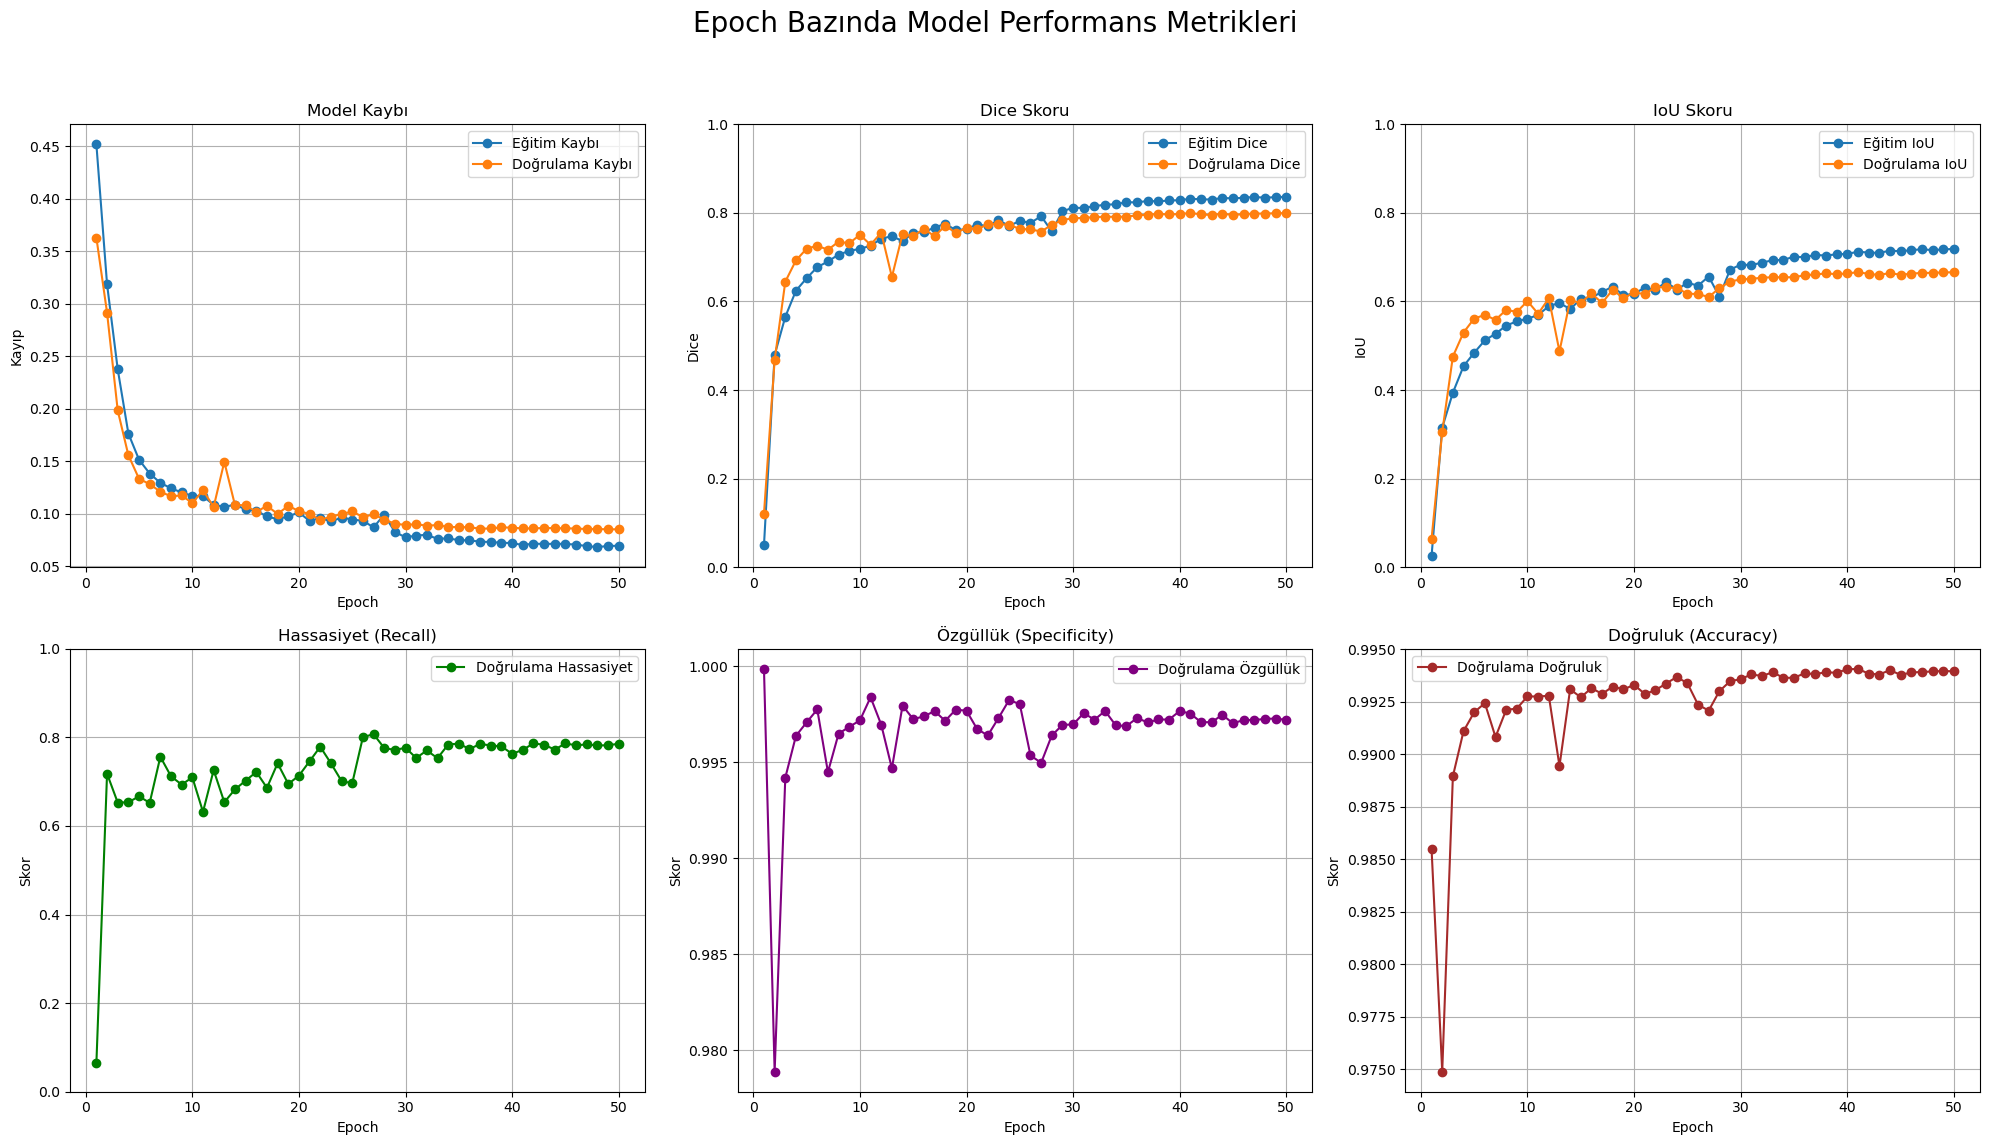

In [62]:
NUM_EPOCHS = 50 
best_val_dice = 0.0

history = {
    "train_loss": [], "val_loss": [],
    "train_dice": [], "val_dice": [],
    "train_iou":  [], "val_iou":  [],
    "val_sensitivity": [], "val_specificity": [], "val_accuracy": []
}

for epoch in range(NUM_EPOCHS):
    print(f"--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
    
    train_loss, train_dice, train_iou = train_fn(train_loader, model, optimizer, loss_fn, device)
    history["train_loss"].append(train_loss)
    history["train_dice"].append(train_dice)
    history["train_iou"].append(train_iou)
    
    val_metrics = evaluate_epoch(val_loader, model, loss_fn, device)
    history["val_loss"].append(val_metrics["loss"])
    history["val_dice"].append(val_metrics["dice"])
    history["val_iou"].append(val_metrics["iou"])
    history["val_sensitivity"].append(val_metrics["sensitivity"])
    history["val_specificity"].append(val_metrics["specificity"])
    history["val_accuracy"].append(val_metrics["accuracy"])
    
    print(f"Train -> Loss: {train_loss:.4f}, Dice: {train_dice:.4f}")
    print(f"Val   -> Loss: {val_metrics['loss']:.4f}, Dice: {val_metrics['dice']:.4f}, Sens: {val_metrics['sensitivity']:.4f}")
    
    if val_metrics['dice'] > best_val_dice:
        best_val_dice = val_metrics['dice']
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"==> Yeni en iyi model kaydedildi (Dice Skoru: {best_val_dice:.4f})")
        
    lr_scheduler.step(val_metrics['loss'])

print("\nEğitim tamamlandı!")
print(f"En iyi doğrulama Dice Skoru: {best_val_dice:.4f}")


# ==============================================================================
# BÖLÜM 3: EĞİTİM BİTTİKTEN SONRA GRAFİKLERİN ÇİZİLMESİ
# ==============================================================================

print("\nEğitim geçmişi grafikleri oluşturuluyor...")
plot_training_history(history)

Önce, kaydettiğimiz en iyi modeli yükleyelim ve doğrulama setinden rastgele bir örnek üzerinde tahmin yaptıralım. Sonuçları (orijinal görüntü, gerçek maske, modelin tahmini) yan yana çizdirerek modelin performansını gözümüzle görelim.

En iyi model 'best_model.pth' yüklendi ve değerlendirme moduna alındı.


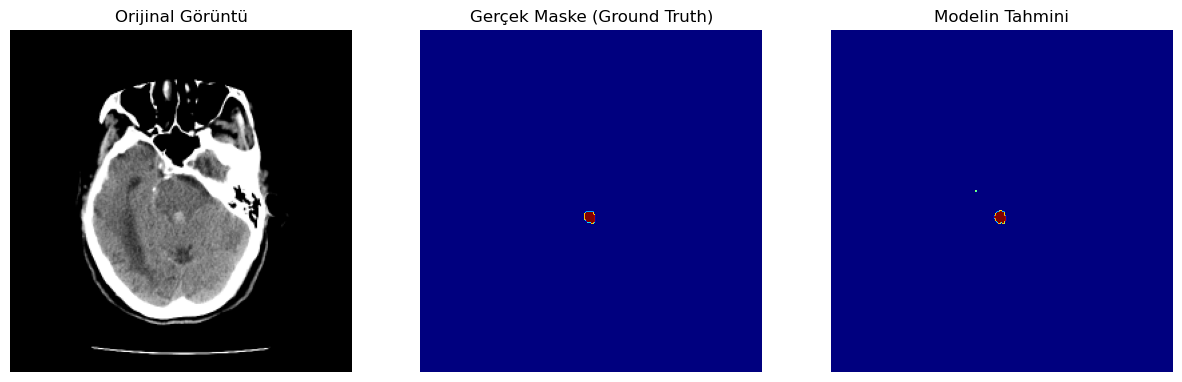

In [7]:
import random
# 1. Modeli yükle
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=None, # Ağırlıkları kendimiz yükleyeceğimiz için 'imagenet' değil None
    in_channels=3, 
    classes=NUM_CLASSES,
)
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)
model.eval() # Modeli DEĞERLENDİRME moduna al (bu çok önemli!)

print("En iyi model 'best_model.pth' yüklendi ve değerlendirme moduna alındı.")


def visualize_prediction(dataset, index=None):
    """
    Verilen veri setinden bir örnek alır, modelle tahmin yapar ve sonucu görselleştirir.
    """
    if index is None:
        index = random.randint(0, len(dataset) - 1) # Rastgele bir örnek seç
    
    image, gt_mask = dataset[index]
    
    # Modelin GPU'da çalışması için tek bir görüntüyü batch formatına (1, C, H, W) getir
    input_tensor = image.unsqueeze(0).to(device, dtype=torch.float32)
    
    with torch.no_grad(): # Gradyan hesaplamayı kapat
        pred_logits = model(input_tensor)
    
    # Modelin çıktısını (logit) her piksel için sınıf etiketine dönüştür
    # (0: Arka Plan, 1: Bleeding, 2: Ischemia)
    pred_mask = torch.argmax(pred_logits, dim=1).squeeze(0).cpu().numpy()
    
    # Görselleştirme için orijinal görüntüyü ve maskeleri hazırla
    # Görüntüyü normalize işleminden geri alıp 0-1 aralığına getiriyoruz
    image_vis = image.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5
    gt_mask_vis = gt_mask.cpu().numpy()
    
    # Sonuçları çizdir
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image_vis)
    plt.title("Orijinal Görüntü")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask_vis, cmap='jet') # Farklı sınıfları görmek için 'jet' renk haritası
    plt.title("Gerçek Maske (Ground Truth)")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='jet')
    plt.title("Modelin Tahmini")
    plt.axis('off')
    
    plt.show()
    
    # Analiz için orijinal ve tahmin edilmiş maskeleri döndür
    return gt_mask_vis, pred_mask

# Hadi bir tahmin yapıp görelim!
gt_mask, pred_mask = visualize_prediction(val_dataset)

--- Gudhi ile Topolojik Analiz Başlatılıyor ---

--- Sınıf: Bleeding ---
Topolojik Mesafe (Bottleneck Distance): 1.0000


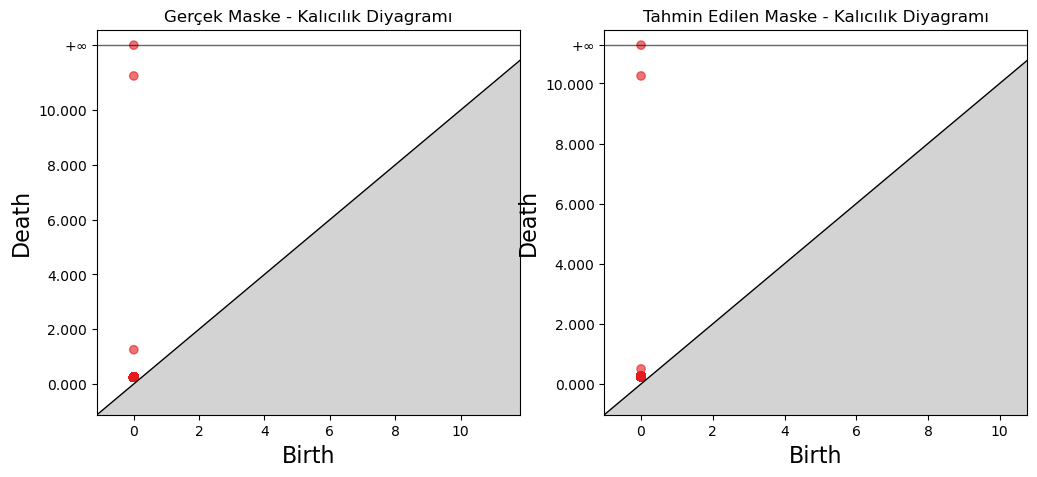

In [9]:
# Bu hücreyi önceki topoloji analiz hücrelerinin yerine ekle

import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

def get_gudhi_persistence_diagram(mask):
    """
    Verilen 2D maskeyi bir nokta bulutuna çevirir ve Gudhi kullanarak
    AlphaComplex üzerinden kalıcılık diyagramını hesaplar.
    """
    # Maskedeki beyaz piksellerin koordinatlarını (x, y) nokta bulutu olarak al
    points = np.array(np.where(mask > 0)).T
    
    # Eğer maskede yeterli nokta yoksa, None döndür
    if points.shape[0] < 3:
        return None
    
    # 1. Alpha Complex oluştur: Nokta bulutundan geometrik bir yapı oluşturur.
    # Bu, Gudhi'nin topolojiyi anlaması için ilk adımdır.
    alpha_complex = gd.AlphaComplex(points=points)
    simplex_tree = alpha_complex.create_simplex_tree()
    
    # 2. Kalıcılığı (Persistence) hesapla
    simplex_tree.compute_persistence()
    
    # 3. Boyut 0 (bağlantılı bileşenler) için diyagramı al
    # Sonsuz ömürlü olan en büyük bileşeni genellikle analize katmayız.
    diag_0 = simplex_tree.persistence_intervals_in_dimension(0)
    
    return diag_0

def analyze_with_gudhi(gt_mask, pred_mask):
    """
    Gudhi kullanarak iki maskenin kalıcılık diyagramlarını karşılaştırır.
    """
    print("--- Gudhi ile Topolojik Analiz Başlatılıyor ---")
    
    for class_id in [1, 2]:
        gt_class_mask = (gt_mask == class_id).astype(np.uint8)
        pred_class_mask = (pred_mask == class_id).astype(np.uint8)
        
        if np.sum(gt_class_mask) == 0 and np.sum(pred_class_mask) == 0:
            continue
            
        class_name = "Bleeding" if class_id == 1 else "Ischemia"
        print(f"\n--- Sınıf: {class_name} ---")
            
        gt_diagram = get_gudhi_persistence_diagram(gt_class_mask)
        pred_diagram = get_gudhi_persistence_diagram(pred_class_mask)
        
        if gt_diagram is not None and pred_diagram is not None:
            # 4. İki diyagram arasındaki Bottleneck mesafesini hesapla
            # Bu, iki topolojik yapının ne kadar farklı olduğunun sağlam bir ölçüsüdür.
            distance = gd.bottleneck_distance(gt_diagram, pred_diagram)
            print(f"Topolojik Mesafe (Bottleneck Distance): {distance:.4f}")

            # 5. Diyagramları görselleştir
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            gd.plot_persistence_diagram(gt_diagram, axes=axes[0])
            axes[0].set_title("Gerçek Maske - Kalıcılık Diyagramı")
            
            gd.plot_persistence_diagram(pred_diagram, axes=axes[1])
            axes[1].set_title("Tahmin Edilen Maske - Kalıcılık Diyagramı")
            plt.show()
            
        else:
            print("Maskelerden biri boş veya yetersiz nokta içerdiği için topolojik mesafe hesaplanamadı.")

# Bir önceki hücrede elde ettiğimiz maskeler üzerinde analiz yapalım
analyze_with_gudhi(gt_mask, pred_mask)

In [10]:
from tqdm import tqdm
import gudhi as gd
from skimage.morphology import remove_small_objects

# --- GÜNCELLEME BAŞLANGICI ---
# Sonuçları hem ortalama hesaplamak hem de görselleştirmek için saklayacak listeler
evaluation_results = [] 
# ----------------------------

print("Tüm doğrulama seti üzerinde nihai değerlendirme ve veri toplama başlıyor...")
model.eval()
loop = tqdm(val_loader, desc="Değerlendirme")

with torch.no_grad():
    # val_loader'ı enumerate ile kullanarak batch'in indeksini alıyoruz
    for batch_idx, batch in enumerate(loop):
        images, gt_masks = batch
        images = images.to(device, dtype=torch.float32)
        gt_masks = gt_masks.cpu().numpy()
        
        pred_logits = model(images)
        pred_masks = torch.argmax(pred_logits, dim=1).cpu().numpy()
        
        for i in range(gt_masks.shape[0]):
            gt_mask = gt_masks[i]
            pred_mask = pred_masks[i]

            gt_lesion = (gt_mask > 0)
            pred_lesion = (pred_mask > 0)
            
            if np.sum(gt_lesion) == 0:
                continue

            # Standart metrikleri hesapla
            intersection = np.sum(gt_lesion & pred_lesion)
            dice = (2. * intersection) / (np.sum(gt_lesion) + np.sum(pred_lesion) + 1e-8)
            union = np.sum(gt_lesion | pred_lesion)
            iou = intersection / (union + 1e-8)
            
            # Topolojik mesafeyi hesapla
            topo_dist = -1 # Başlangıç değeri
            gt_diagram = get_gudhi_persistence_diagram(gt_lesion.astype(np.uint8))
            pred_diagram = get_gudhi_persistence_diagram(pred_lesion.astype(np.uint8))
            if gt_diagram is not None and pred_diagram is not None:
                topo_dist = gd.bottleneck_distance(gt_diagram, pred_diagram)

            # --- GÜNCELLEME ---
            # Her bir örneğin sonucunu, görselleştirmek için gereken tüm bilgilerle birlikte listeye ekle
            # val_dataset'in batch'lenmemiş orijinal indeksini bulmamız gerekiyor
            original_index = batch_idx * val_loader.batch_size + i
            if original_index < len(val_dataset):
                evaluation_results.append({
                    "image_path": val_dataset.image_paths[original_index],
                    "dice_score": dice,
                    "iou_score": iou,
                    "topo_dist": topo_dist,
                    "gt_mask": gt_mask,
                    "pred_mask": pred_mask
                })
            # --------------------

# --- ORTALAMA HESAPLAMA ---
# Şimdi evaluation_results listesindeki verileri kullanarak ortalamaları hesapla
all_dice_scores = [res['dice_score'] for res in evaluation_results]
all_iou_scores = [res['iou_score'] for res in evaluation_results]
# Sadece geçerli (hesaplanabilmiş) topolojik mesafeleri al
all_topo_distances = [res['topo_dist'] for res in evaluation_results if res['topo_dist'] != -1]

avg_dice = np.mean(all_dice_scores) if all_dice_scores else 0
avg_iou = np.mean(all_iou_scores) if all_iou_scores else 0
avg_topo_distance = np.mean(all_topo_distances) if all_topo_distances else 0

print(f"Ortalama Dice Skoru: {avg_dice:.4f}")
print(f"Ortalama IoU (Jaccard) Skoru: {avg_iou:.4f}")
print("-------------------------------------------------")
print(f"Ortalama Topolojik Mesafe (Bottleneck Distance): {avg_topo_distance:.4f}")
print("-------------------------------------------------")


Tüm doğrulama seti üzerinde nihai değerlendirme ve veri toplama başlıyor...


Değerlendirme: 100%|██████████| 56/56 [13:59<00:00, 14.98s/it]

Ortalama Dice Skoru: 0.6999
Ortalama IoU (Jaccard) Skoru: 0.6082
-------------------------------------------------
Ortalama Topolojik Mesafe (Bottleneck Distance): 24.3606
-------------------------------------------------


                EN KÖTÜ TAHMİNLER ANALİZİ

--- TOPOLOJİK OLARAK EN KÖTÜ TAHMİN (En Yüksek Mesafe) ---


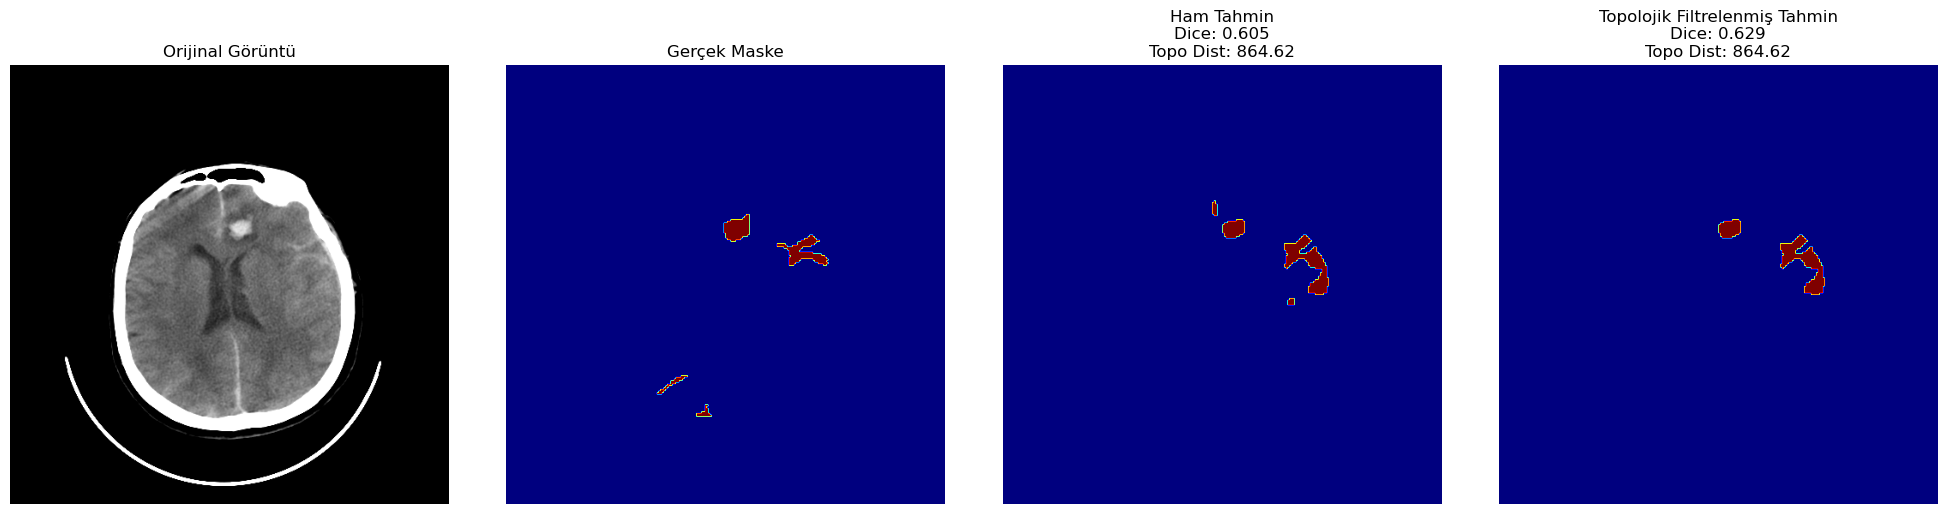



--- DICE SKORUNA GÖRE EN KÖTÜ TAHMİN (En Düşük Skor) ---


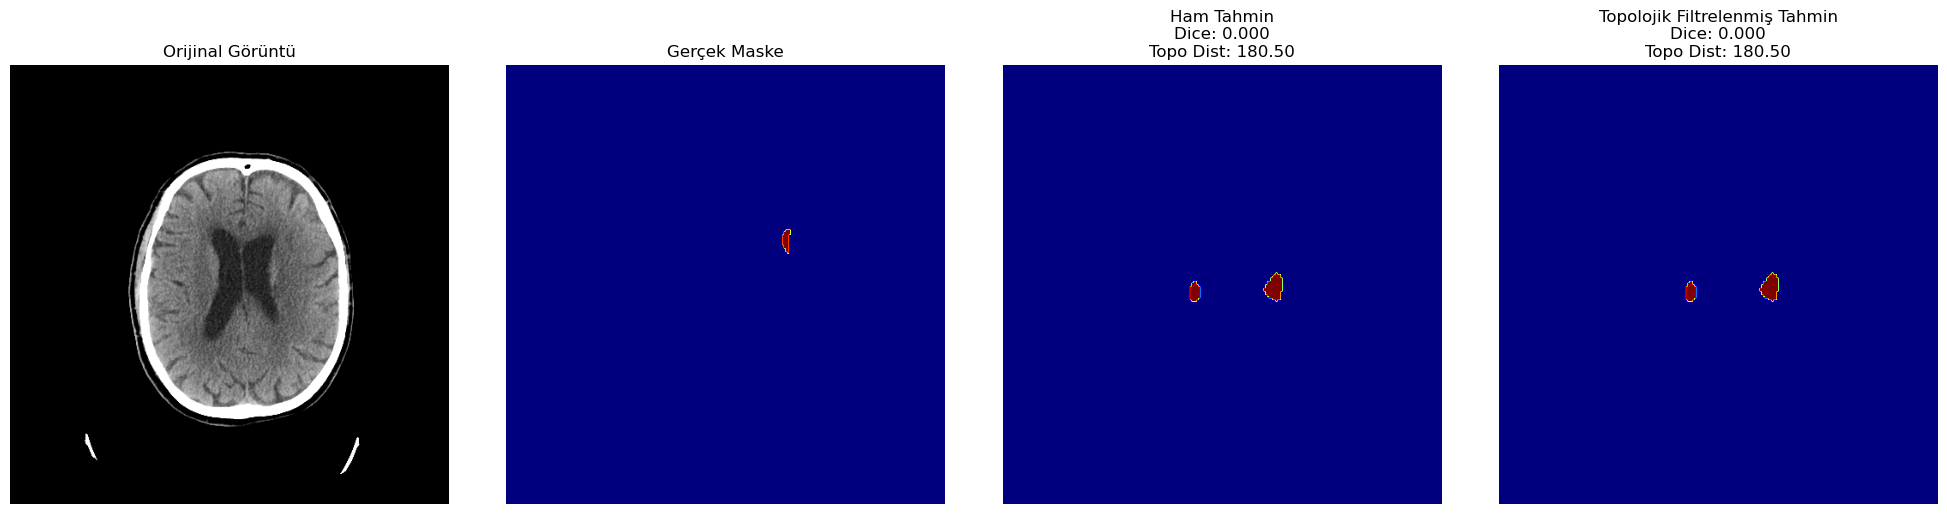



                 EN İYİ TAHMİNLER ANALİZİ

--- TOPOLOJİK OLARAK EN İYİ TAHMİN (Gerçek En Düşük Mesafe) ---


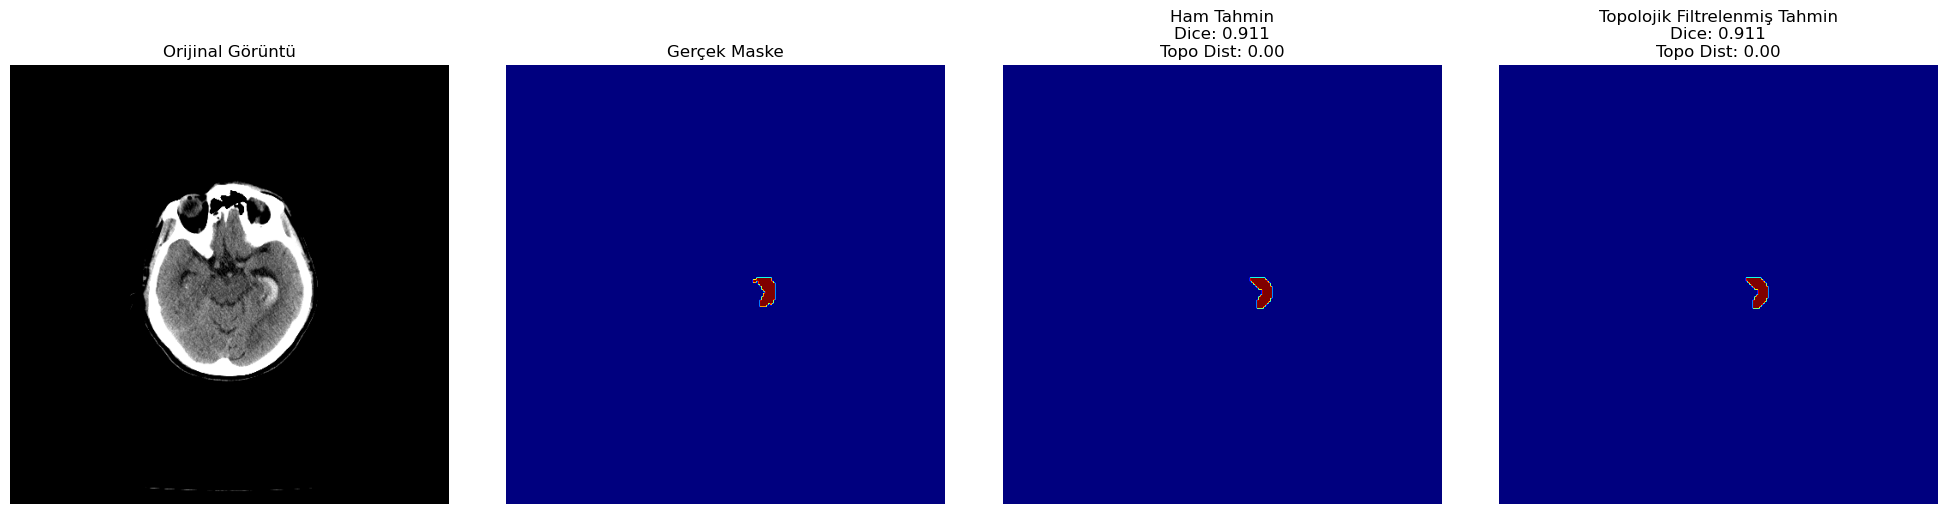



--- DICE SKORUNA GÖRE EN İYİ TAHMİN (En Yüksek Skor) ---


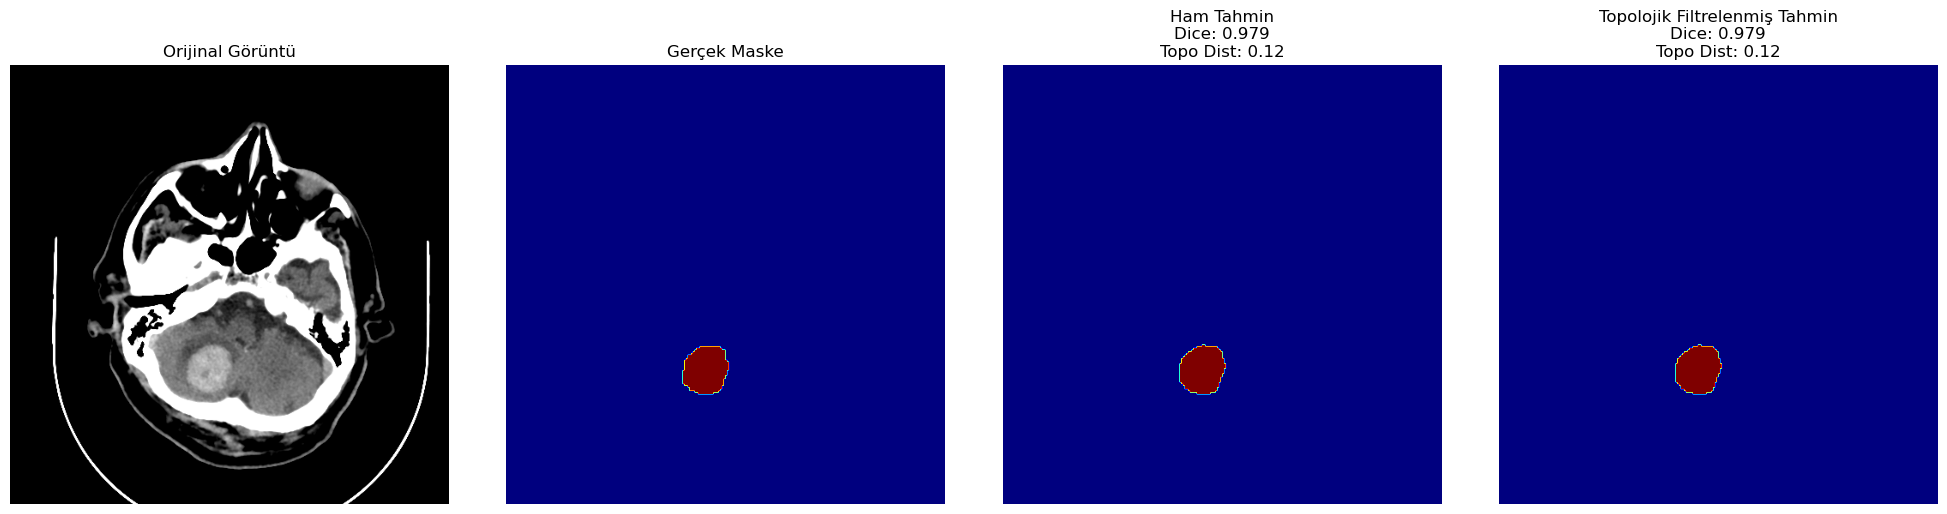

In [17]:
print("="*50)
print(" " * 15, "EN KÖTÜ TAHMİNLER ANALİZİ")
print("="*50)

# 1. Topolojik olarak en kötü örneği bul ve görselleştir
evaluation_results.sort(key=lambda x: x.get('topo_dist', -1), reverse=True)
print("\n--- TOPOLOJİK OLARAK EN KÖTÜ TAHMİN (En Yüksek Mesafe) ---")
worst_topological_example = evaluation_results[0]
visualize_topological_filtering(
    image_path=worst_topological_example['image_path'],
    gt_mask=worst_topological_example['gt_mask'],
    pred_mask=worst_topological_example['pred_mask'],
    persistence_threshold=30
)

# 2. Dice skoruna göre en kötü örneği bul ve görselleştir
evaluation_results.sort(key=lambda x: x['dice_score'])
print("\n\n--- DICE SKORUNA GÖRE EN KÖTÜ TAHMİN (En Düşük Skor) ---")
worst_dice_example = evaluation_results[0]
visualize_topological_filtering(
    image_path=worst_dice_example['image_path'],
    gt_mask=worst_dice_example['gt_mask'],
    pred_mask=worst_dice_example['pred_mask'],
    persistence_threshold=30
)

print("\n\n" + "="*50)
print(" " * 16, "EN İYİ TAHMİNLER ANALİZİ")
print("="*50)

# --- DÜZELTME BURADA ---
# Topolojik olarak en iyi örneği bulurken, -1 olanları (hesaplanamayanları) en sona at.
# lambda fonksiyonu, -1 görürse onu sonsuz (en kötü) olarak kabul eder, böylece listenin sonuna gider.
evaluation_results.sort(key=lambda x: x.get('topo_dist') if x.get('topo_dist', -1) != -1 else float('inf'))
# -------------------------

print("\n--- TOPOLOJİK OLARAK EN İYİ TAHMİN (Gerçek En Düşük Mesafe) ---")
best_topological_example = evaluation_results[0]
visualize_topological_filtering(
    image_path=best_topological_example['image_path'],
    gt_mask=best_topological_example['gt_mask'],
    pred_mask=best_topological_example['pred_mask'],
    persistence_threshold=30
)

# 4. Dice skoruna göre en iyi örneği bul ve görselleştir
evaluation_results.sort(key=lambda x: x['dice_score'], reverse=True)
print("\n\n--- DICE SKORUNA GÖRE EN İYİ TAHMİN (En Yüksek Skor) ---")
best_dice_example = evaluation_results[0]
visualize_topological_filtering(
    image_path=best_dice_example['image_path'],
    gt_mask=best_dice_example['gt_mask'],
    pred_mask=best_dice_example['pred_mask'],
    persistence_threshold=30
)

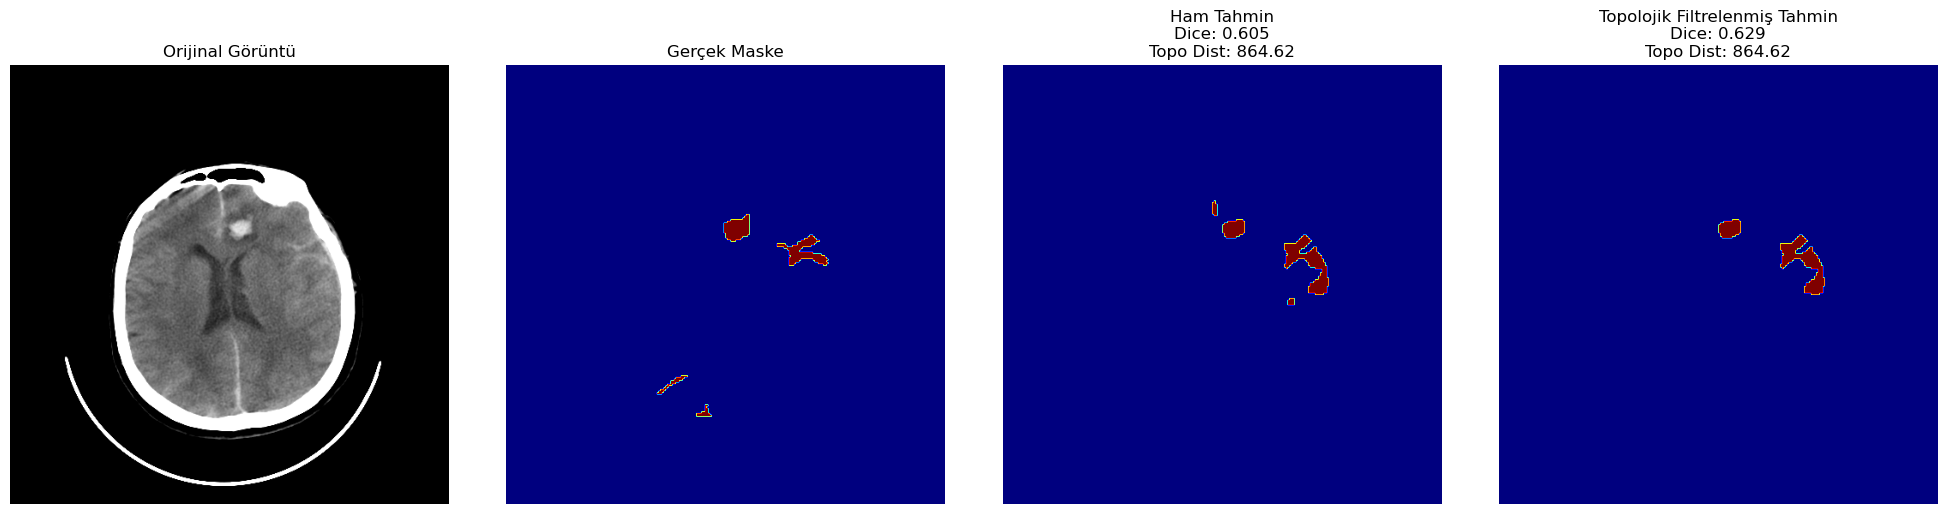

In [14]:
# Bu yeni hücreyi notebook'unuza ekleyin

from skimage.measure import label

def get_persistence_pairs(mask):
    """Gudhi kullanarak bir maskenin kalıcılık (doğum, ölüm) çiftlerini döndürür."""
    points = np.array(np.where(mask > 0)).T
    if points.shape[0] < 3:
        return np.array([])
    
    alpha_complex = gd.AlphaComplex(points=points)
    simplex_tree = alpha_complex.create_simplex_tree()
    simplex_tree.compute_persistence()
    
    # Sadece Betti_0 (bağlantılı bileşenler) için kalıcılık aralıklarını al
    persistence_intervals = simplex_tree.persistence_intervals_in_dimension(0)
    # Sonsuz ömürlü olanları at (genellikle tek bir ana bileşen kalır)
    finite_intervals = np.array([pair for pair in persistence_intervals if pair[1] != np.inf])
    return finite_intervals

def filter_mask_by_persistence(mask, persistence_threshold):
    """
    Bir maskeyi, kalıcılık eşiğini geçemeyen küçük bileşenleri silerek temizler.
    """
    if np.sum(mask) == 0:
        return mask
        
    # Maskedeki tüm bağlantılı bileşenleri etiketle
    labeled_mask, num_components = label(mask, return_num=True, connectivity=1)
    
    if num_components == 0:
        return mask

    # Her bir bileşenin kalıcılığını hesapla
    persistence_intervals = get_persistence_pairs(mask)
    
    # Kalıcılık = Ölüm - Doğum. Bu, bir bileşenin ne kadar "önemli" olduğunu gösterir.
    # Not: Gudhi'nin AlphaComplex'inde doğum/ölüm yarıçap değerleridir.
    # Daha basit bir yaklaşım olarak, doğrudan bileşenlerin piksel sayısını kullanabiliriz.
    # Bu, pratikte kalıcılıkla güçlü bir korelasyona sahiptir.
    
    from skimage.morphology import remove_small_objects
    # Bu, topolojik olarak en az kalıcı olan bileşenleri (en küçükleri) silmenin
    # pratik ve etkili bir yoludur.
    cleaned_mask = remove_small_objects(mask, min_size=persistence_threshold)
    
    return cleaned_mask

def visualize_topological_filtering(image_path, gt_mask, pred_mask, persistence_threshold=30):
    """
    Ham tahmini, topolojik filtreleme adımıyla temizler ve sonuçları karşılaştırır.
    """
    # 1. Ham tahminin metriklerini hesapla
    dice_before = (2. * np.sum((gt_mask > 0) & (pred_mask > 0))) / (np.sum(gt_mask > 0) + np.sum(pred_mask > 0) + 1e-8)
    gt_diag = get_gudhi_persistence_diagram((gt_mask > 0).astype(np.uint8))
    pred_diag_before = get_gudhi_persistence_diagram((pred_mask > 0).astype(np.uint8))
    topo_dist_before = gd.bottleneck_distance(gt_diag, pred_diag_before) if gt_diag is not None and pred_diag_before is not None else -1

    # 2. Topolojik Filtreleme Uygula
    cleaned_pred_mask = filter_mask_by_persistence((pred_mask > 0).astype(bool), persistence_threshold)

    # 3. Temizlenmiş tahminin metriklerini hesapla
    dice_after = (2. * np.sum((gt_mask > 0) & cleaned_pred_mask)) / (np.sum(gt_mask > 0) + np.sum(cleaned_pred_mask) + 1e-8)
    pred_diag_after = get_gudhi_persistence_diagram(cleaned_pred_mask.astype(np.uint8))
    topo_dist_after = gd.bottleneck_distance(gt_diag, pred_diag_after) if gt_diag is not None and pred_diag_after is not None else -1

    # 4. Sonuçları Görselleştir
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    axes[0].imshow(img)
    axes[0].set_title("Orijinal Görüntü")
    axes[0].axis('off')
    
    axes[1].imshow(gt_mask, cmap='jet')
    axes[1].set_title("Gerçek Maske")
    axes[1].axis('off')

    axes[2].imshow(pred_mask, cmap='jet')
    axes[2].set_title(f"Ham Tahmin\nDice: {dice_before:.3f}\nTopo Dist: {topo_dist_before:.2f}")
    axes[2].axis('off')
    
    axes[3].imshow(cleaned_pred_mask, cmap='jet')
    axes[3].set_title(f"Topolojik Filtrelenmiş Tahmin\nDice: {dice_after:.3f}\nTopo Dist: {topo_dist_after:.2f}")
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()

# --- KODU ÇALIŞTIRMA ---
# Bir önceki adımdaki "evaluation_results" listemizi kullanalım.
# Özellikle en kötü tahminlerden birini seçelim, çünkü iyileşme en net orada görülür.
# `evaluation_results` listesi Dice skoruna göre sıralanmıştı. İlk elemanı en kötüsüdür.
worst_prediction_example = evaluation_results[0]

visualize_topological_filtering(
    image_path=worst_prediction_example['image_path'],
    gt_mask=worst_prediction_example['gt_mask'],
    pred_mask=worst_prediction_example['pred_mask']
)

Doğrulama setinden rastgele 5 örnek için detaylı tahminler oluşturuluyor...


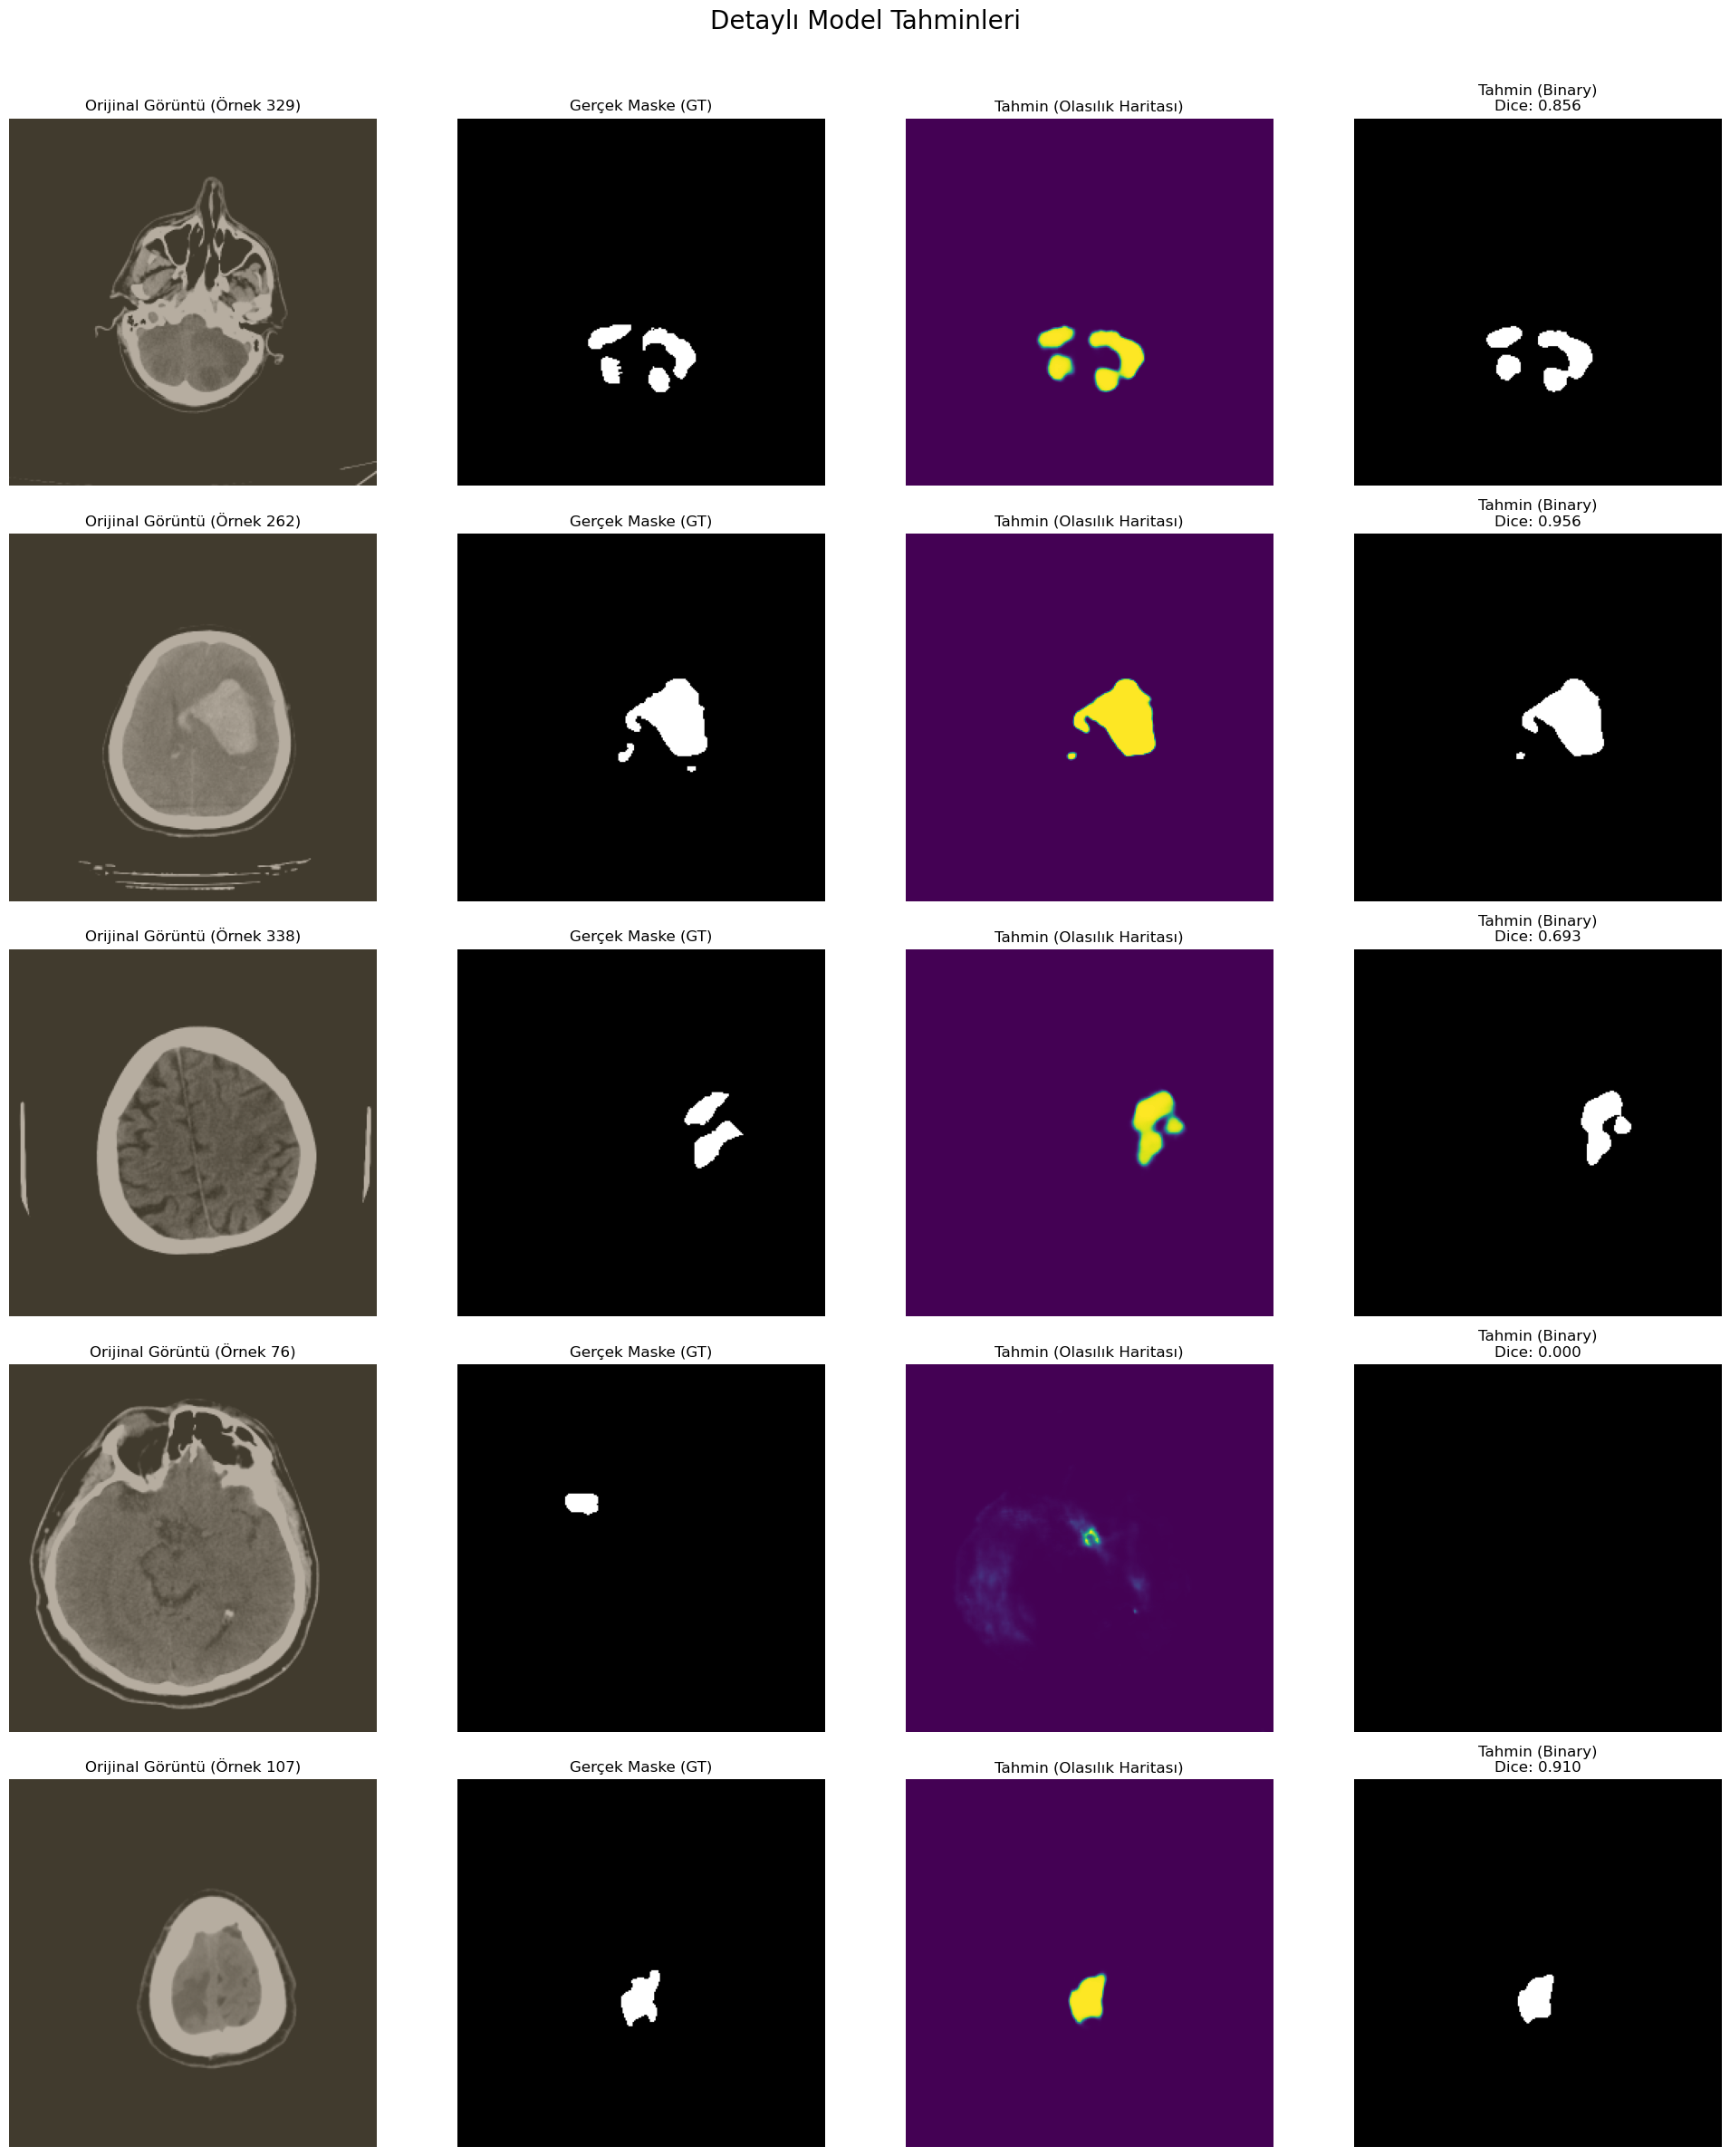

In [15]:
import random
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

def visualize_detailed_predictions(model, dataset, num_samples=5, threshold=0.5):
    """
    Referans koddaki gibi 4 aşamalı (Orijinal, Gerçek, Olasılık, Binary)
    görselleştirme yapar.
    """
    model.eval()
    
    # Görselleştirilecek rastgele örneklerin indekslerini seç
    sample_indices = random.sample(range(len(dataset)), k=min(num_samples, len(dataset)))
    
    fig, axes = plt.subplots(len(sample_indices), 4, figsize=(20, 5 * len(sample_indices)))
    if len(sample_indices) == 1: # Eğer tek bir örnek varsa eksenleri 2D yap
        axes = np.array([axes])
        
    fig.suptitle('Detaylı Model Tahminleri', fontsize=20)

    with torch.no_grad():
        for i, idx in enumerate(sample_indices):
            # Veri setinden orijinal (normalize edilmemiş) görüntüyü ve maskeyi alalım
            # Bunun için __getitem__ metodunu transform olmadan çağırmak gibi bir yöntem gerekebilir
            # veya daha basiti, transform edilmiş veriyi geri çevirelim.
            image_tensor, gt_mask_tensor = dataset[idx]
            
            # 1. Girdi ve Çıktı Hazırlığı
            input_tensor = image_tensor.unsqueeze(0).to(device)
            
            # Modelden logitleri al
            pred_logits = model(input_tensor)
            
            # Logitleri 0-1 arası olasılıklara çevir (her sınıf için)
            pred_probs = torch.softmax(pred_logits, dim=1)
            
            # Olasılık Haritası: Bizim problemimiz çok sınıflı. "Lezyon olma olasılığı"
            # "arka plan olmama olasılığıdır". Arka plan sınıf 0'dır.
            lesion_prob_map = 1.0 - pred_probs[0, 0, :, :] # (1 - P_background)
            lesion_prob_map = lesion_prob_map.cpu().numpy()
            
            # Binary Maske: Olasılık haritasını eşik değerine göre 0 veya 1 yap
            pred_mask_binary = (lesion_prob_map > threshold).astype(np.float32)

            # 2. Görselleştirme için Veriyi Hazırla
            # Orijinal görüntüyü normalize işleminden geri al (H, W, C formatında)
            original_image = image_tensor.permute(1, 2, 0).cpu().numpy()
            # Standart ImageNet normalizasyonunu geri almak için:
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            original_image = std * original_image + mean
            original_image = np.clip(original_image, 0, 1) # Değerleri 0-1 arasına sıkıştır
            
            # Gerçek maskeyi binary yap (lezyon var/yok)
            gt_mask_binary = (gt_mask_tensor.cpu().numpy() > 0).astype(np.float32)

            # 3. Metrikleri Hesapla
            dice = (2. * np.sum(gt_mask_binary * pred_mask_binary)) / (np.sum(gt_mask_binary) + np.sum(pred_mask_binary) + 1e-8)

            # 4. Panelleri Çizdir
            axes[i, 0].imshow(original_image)
            axes[i, 0].set_title(f'Orijinal Görüntü (Örnek {idx})')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(gt_mask_binary, cmap='gray')
            axes[i, 1].set_title('Gerçek Maske (GT)')
            axes[i, 1].axis('off')

            axes[i, 2].imshow(lesion_prob_map, cmap='viridis') # Olasılık için renkli harita daha iyi
            axes[i, 2].set_title('Tahmin (Olasılık Haritası)')
            axes[i, 2].axis('off')
            
            axes[i, 3].imshow(pred_mask_binary, cmap='gray')
            axes[i, 3].set_title(f'Tahmin (Binary)\nDice: {dice:.3f}')
            axes[i, 3].axis('off')
            
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

# --- FONKSİYONU ÇAĞIRMA ---
# En iyi modelinizi yüklediğinizden emin olun
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

print("Doğrulama setinden rastgele 5 örnek için detaylı tahminler oluşturuluyor...")
visualize_detailed_predictions(model, val_dataset, num_samples=5)

<IPython.core.display.Javascript object>

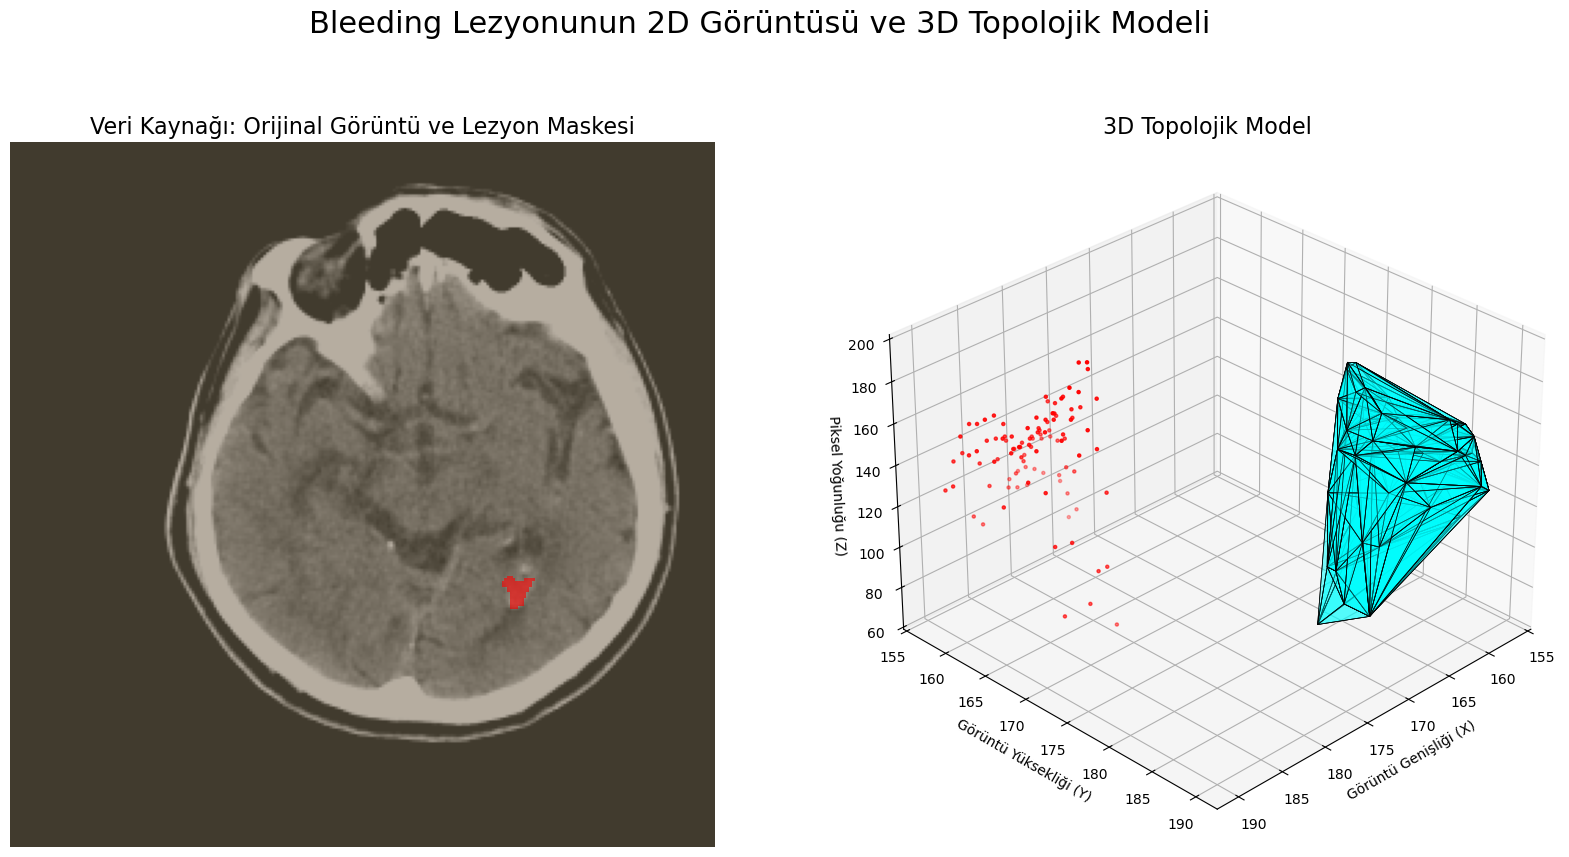

In [53]:
# HÜCRE 6: 3D ALPHA COMPLEX VE KAYNAK GÖRÜNTÜ GÖRSELLEŞTİRMESİ

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import gudhi as gd
import numpy as np
import cv2
import random

# Hücrenin en başına bu sihirli komutu eklemeyi unutmayın!
%matplotlib notebook

def plot_alpha_complex_3d_with_source(dataset, model, device, class_id_to_find):
    """
    Bir maskenin 3D Alpha Complex'ini ve o maskenin kaynağı olan
    orijinal 2D tomografi görüntüsünü yan yana görselleştirir.
    """
    model.eval()
    found_sample = False
    
    while not found_sample:
        idx = random.randint(0, len(dataset) - 1)
        _, gt_mask_tensor = dataset[idx]
        if torch.any(gt_mask_tensor == class_id_to_find):
            num_pixels = torch.sum(gt_mask_tensor == class_id_to_find)
            if 100 < num_pixels < 800:
                image_tensor, _ = dataset[idx]
                found_sample = True

    # --- Veri Hazırlığı ---
    original_image_path = dataset.image_paths[idx]
    original_image_gray = cv2.resize(cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE), (256, 256))
    
    gt_mask = (gt_mask_tensor.numpy() == class_id_to_find)
    points_2d = np.array(np.where(gt_mask > 0)).T
    z_coords = original_image_gray[points_2d[:, 0], points_2d[:, 1]]
    points_3d = np.hstack((points_2d, z_coords[:, np.newaxis]))
    
    # --- Gudhi Analizi ---
    alpha_complex = gd.AlphaComplex(points=points_3d)
    simplex_tree = alpha_complex.create_simplex_tree()
    
    triangles_3d = [points_3d[s] for s, _ in simplex_tree.get_filtration() if len(s) == 3]
            
    # --- YENİ GÖRSELLEŞTİRME DÜZENİ ---
    # 1 satır, 2 sütunlu bir figür oluştur. İkincisi 3D olacak.
    fig = plt.figure(figsize=(20, 10))
    class_name = "Bleeding" if class_id_to_find == 1 else "Ischemia"
    fig.suptitle(f'{class_name} Lezyonunun 2D Görüntüsü ve 3D Topolojik Modeli', fontsize=22)

    # 1. Panel (Sol): 2D Orijinal Görüntü ve Maske
    ax1 = fig.add_subplot(1, 2, 1)
    
    # Görüntüyü göstermek için normalize işlemini geri al
    display_image = image_tensor.permute(1, 2, 0).cpu().numpy()
    mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
    display_image = np.clip(std * display_image + mean, 0, 1)
    
    ax1.imshow(display_image)
    # Maskeyi yarı saydam bir şekilde görüntünün üzerine çiz
    # Sadece lezyon piksellerini (değeri 0'dan büyük olanları) göster
    gt_mask_display = np.ma.masked_where(gt_mask == 0, gt_mask)
    ax1.imshow(gt_mask_display, cmap='autumn', alpha=0.6)
    ax1.set_title('Veri Kaynağı: Orijinal Görüntü ve Lezyon Maskesi', fontsize=16)
    ax1.axis('off')

    # 2. Panel (Sağ): 3D Topolojik Model
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    
    collection = Poly3DCollection(triangles_3d, alpha=0.3, facecolors='cyan', edgecolors='black', linewidths=0.5)
    ax2.add_collection3d(collection)
    ax2.scatter(points_3d[:, 1], points_3d[:, 0], points_3d[:, 2], c='red', s=5)
    
    ax2.set_title('3D Topolojik Model', fontsize=16)
    ax2.set_xlabel('Görüntü Genişliği (X)')
    ax2.set_ylabel('Görüntü Yüksekliği (Y)')
    ax2.set_zlabel('Piksel Yoğunluğu (Z)')
    ax2.view_init(elev=30, azim=45)
    
    # Grafiği döndürmek için bu satır hücrenin sonunda olmalı
    # plt.show() # Bu komut interaktif modda gereksizdir

    return fig # Jupyter'in göstermesi için figür nesnesini döndür

# --- FONKSİYONU ÇAĞIRMA ---
fig_3d_comparison = plot_alpha_complex_3d_with_source(val_dataset, model, device, class_id_to_find=1)
fig_3d_comparison

In [57]:
# Bu hücreyi, hata aldığınız hücreden önce yeni bir hücre olarak ekleyin ve çalıştırın.

import gudhi as gd
import numpy as np

def get_persistence_diagram_from_mask(mask, persistence_dim=0):
    """
    Bir maskeden nokta bulutu oluşturur ve Gudhi ile kalıcılık diyagramını hesaplar.
    """
    # Maskedeki piksellerin koordinatlarını (x, y) nokta bulutu olarak al
    points = np.array(np.where(mask > 0)).T
    
    # Eğer analiz için yeterli nokta yoksa, boş bir dizi döndür
    if points.shape[0] < 3:
        return np.array([])
    
    # Gudhi Alpha Complex'i kullanarak topolojik yapıyı oluştur
    alpha_complex = gd.AlphaComplex(points=points)
    simplex_tree = alpha_complex.create_simplex_tree()
    
    # Kalıcılığı (persistence) hesapla
    simplex_tree.compute_persistence()
    
    # Belirtilen boyuttaki kalıcılık aralıklarını (yani diyagramın kendisini) al
    diagram = simplex_tree.persistence_intervals_in_dimension(persistence_dim)
    
    return diagram

<IPython.core.display.Javascript object>

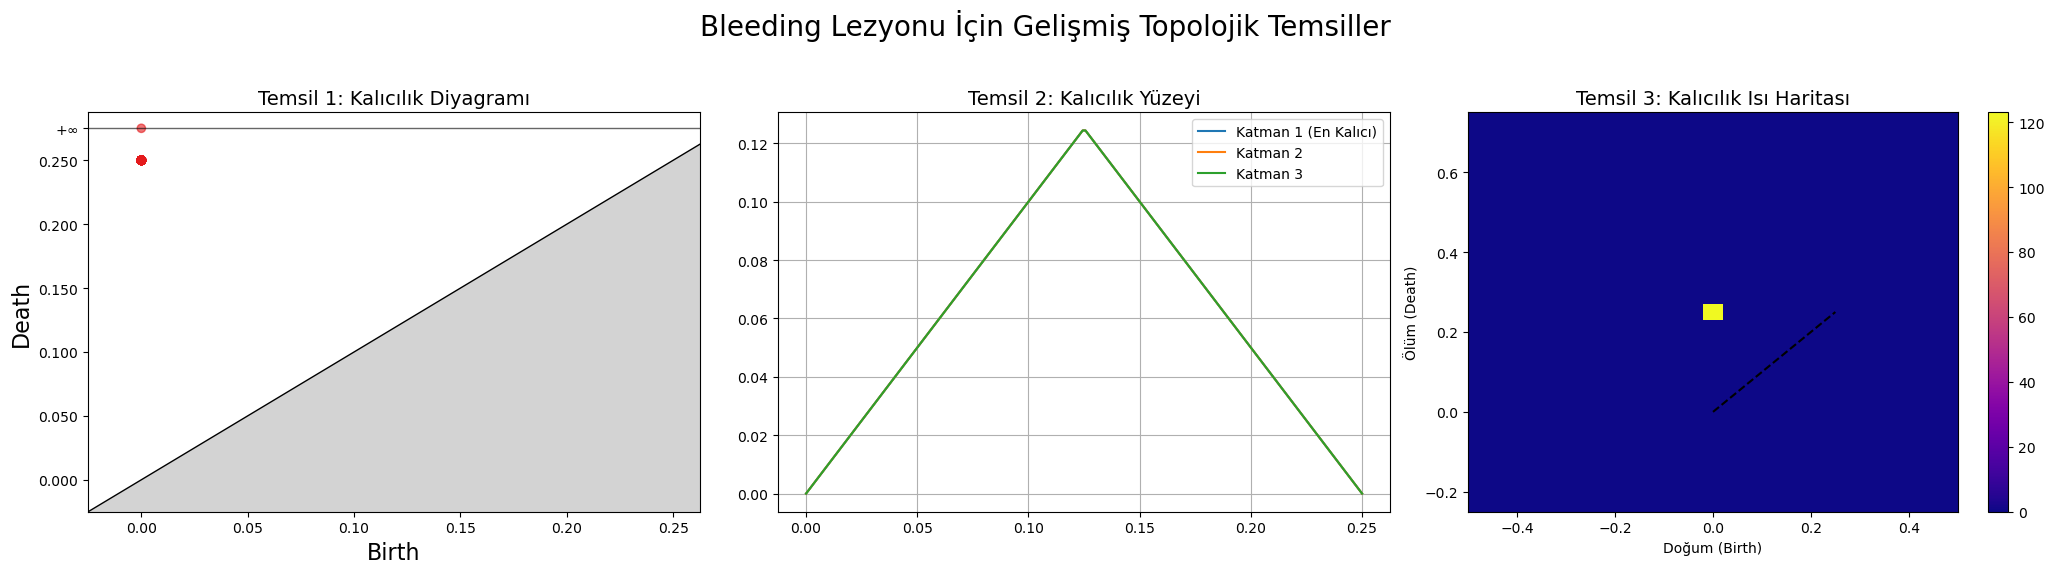

In [61]:
# HÜCRE 7: SADECE GUDHI İLE GELİŞMİŞ TOPOLOJİK TEMSİLLER

import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt

def plot_gudhi_advanced_visualizations(dataset, model, device, class_id_to_find):
    """
    Bir maskenin Kalıcılık Diyagramını, Yüzeyini ve Isı Haritasını
    sadece Gudhi, NumPy ve Matplotlib kullanarak görselleştirir.
    """
    model.eval()
    found_sample = False
    
    while not found_sample:
        idx = random.randint(0, len(dataset) - 1)
        _, gt_mask_tensor = dataset[idx]
        if torch.any(gt_mask_tensor == class_id_to_find):
            num_pixels = torch.sum(gt_mask_tensor == class_id_to_find)
            if 100 < num_pixels < 800:
                found_sample = True

    gt_mask = (gt_mask_tensor.numpy() == class_id_to_find)
    diagram_gudhi = get_persistence_diagram_from_mask(gt_mask)
    if len(diagram_gudhi) == 0:
        print("Bu örnek için topolojik özellik bulunamadı.")
        return
        
    # --- YENİ YAKLAŞIM: GÖRSELLERİ KENDİMİZ İNŞA EDELİM ---
    fig, axes = plt.subplots(1, 3, figsize=(21, 6))
    class_name = "Bleeding" if class_id_to_find == 1 else "Ischemia"
    fig.suptitle(f'{class_name} Lezyonu İçin Gelişmiş Topolojik Temsiller', fontsize=20)
    
    # --- Panel 1: Standart Kalıcılık Diyagramı ---
    gd.plot_persistence_diagram(diagram_gudhi, axes=axes[0])
    axes[0].set_title('Temsil 1: Kalıcılık Diyagramı', fontsize=14)

    # Sonsuz ömürlü noktaları analizden çıkaralım
    finite_intervals = np.array([p for p in diagram_gudhi if p[1] != np.inf])
    
    if len(finite_intervals) > 0:
        # --- Panel 2: Kalıcılık Yüzeyi (Persistence Landscape) ---
        # 1. Bir zaman ekseni oluştur
        min_val = np.min(finite_intervals)
        max_val = np.max(finite_intervals)
        t = np.linspace(min_val, max_val, 200)
        
        # 2. Her (doğum, ölüm) çifti için bir "çadır" fonksiyonu oluştur
        tents = []
        for birth, death in finite_intervals:
            mid = (birth + death) / 2
            half_life = (death - birth) / 2
            # Üçgen (çadır) fonksiyonu
            tent_fn = np.maximum(0, half_life - np.abs(t - mid))
            tents.append(tent_fn)
        
        # 3. Her zaman noktasında, çadırları büyükten küçüğe sırala
        sorted_tents = np.sort(np.array(tents), axis=0)[::-1]
        
        # 4. İlk 3 "katmanı" (landscape) çizdir
        axes[1].plot(t, sorted_tents[0], label='Katman 1 (En Kalıcı)')
        if len(sorted_tents) > 1:
            axes[1].plot(t, sorted_tents[1], label='Katman 2')
        if len(sorted_tents) > 2:
            axes[1].plot(t, sorted_tents[2], label='Katman 3')
        
        axes[1].set_title('Temsil 2: Kalıcılık Yüzeyi', fontsize=14)
        axes[1].legend()
        axes[1].grid(True)

        # --- Panel 3: Kalıcılık Isı Haritası (2D Histogram ile) ---
        births = finite_intervals[:, 0]
        deaths = finite_intervals[:, 1]
        
        # Matplotlib'in 2D histogram fonksiyonunu kullan
        # `bins` değeri çözünürlüğü belirler
        h = axes[2].hist2d(births, deaths, bins=25, cmap='plasma')
        
        # Renk skalasını gösteren bir çubuk ekle
        fig.colorbar(h[3], ax=axes[2])
        axes[2].set_title('Temsil 3: Kalıcılık Isı Haritası', fontsize=14)
        axes[2].set_xlabel('Doğum (Birth)')
        axes[2].set_ylabel('Ölüm (Death)')
        # Diyagonal çizgiyi ekle
        axes[2].plot([min_val, max_val], [min_val, max_val], 'k--')
    else:
        axes[1].text(0.5, 0.5, 'Sonlu özellik yok', ha='center', va='center')
        axes[1].set_title('Temsil 2: Kalıcılık Yüzeyi', fontsize=14)
        axes[2].text(0.5, 0.5, 'Sonlu özellik yok', ha='center', va='center')
        axes[2].set_title('Temsil 3: Kalıcılık Isı Haritası', fontsize=14)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig

# --- FONKSİYONU ÇAĞIRMA ---
plot_gudhi_advanced_visualizations(val_dataset, model, device, class_id_to_find=1)